<a href="https://colab.research.google.com/github/arlou022/Arlou-Astrologia---6.S191/blob/main/Part_B_c23109917.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT012 - Credit Risk Scoring Coursework Part B

# Installing necessary libraries

In [1]:
pip install optbinning

In [2]:
from optbinning import OptimalBinning

(CVXPY) May 01 12:52:19 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 01 12:52:19 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# Initial EDA

Brief overview of the dataset to gather an idea of what's going on.

**Note:** Drag and drop data into files in order for code to run.

In [4]:
# Load in data and initial inspection
df = pd.read_excel('/content/GermanCreditData.xlsx', sheet_name = 'Sheet1')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Checking   1000 non-null   int64 
 1   Duration   1000 non-null   int64 
 2   History    1000 non-null   int64 
 3   Purpose    1000 non-null   object
 4   Amount     1000 non-null   int64 
 5   Savings    1000 non-null   int64 
 6   Emploed    1000 non-null   int64 
 7   Installp   1000 non-null   int64 
 8   marital    1000 non-null   int64 
 9   Coapp      1000 non-null   int64 
 10  Resident   1000 non-null   int64 
 11  Property   1000 non-null   int64 
 12  Age        1000 non-null   int64 
 13  Other      1000 non-null   int64 
 14  housing    1000 non-null   int64 
 15  Existcr    1000 non-null   int64 
 16  Job        1000 non-null   int64 
 17  Depends    1000 non-null   int64 
 18  Telephone  1000 non-null   int64 
 19  Foreign    1000 non-null   int64 
 20  Bad        1000 non-null   int6

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,...,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Bad,Good
0,1,6,4,3,1169,5,5,4,3,1,...,67,3,2,2,3,1,2,1,0,1
1,2,48,2,3,5951,1,3,2,2,1,...,22,3,2,1,3,1,1,1,1,0
2,4,12,4,6,2096,1,4,2,3,1,...,49,3,2,1,2,2,1,1,0,1
3,1,42,2,2,7882,1,4,2,3,3,...,45,3,3,1,3,2,1,1,0,1
4,1,24,3,0,4870,1,3,3,3,1,...,53,3,3,2,3,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,2,1736,1,4,3,2,1,...,31,3,2,1,2,1,1,1,0,1
996,1,30,2,1,3857,1,3,4,1,1,...,40,3,2,1,4,1,2,1,0,1
997,4,12,2,3,804,1,5,4,3,1,...,38,3,2,1,3,1,1,1,0,1
998,1,45,2,3,1845,1,3,4,3,1,...,23,3,3,1,3,1,2,1,1,0


## Check for missing values

In [5]:
# Check for missing values

# Make it a dataframe so it looks nice
missing_values_count_df = pd.DataFrame(df.isna().sum()).reset_index()
missing_values_count_df.columns = ['Variable', 'Missing Values Count']
missing_values_count_df

,Variable,Missing Values Count
0,Checking,0
1,Duration,0
2,History,0
3,Purpose,0
4,Amount,0
5,Savings,0
6,Emploed,0
7,Installp,0
8,marital,0
9,Coapp,0


In [6]:
# Only need one of either 'Good' or 'Bad' column
df.drop(columns=['Bad'], inplace=True)

In [7]:
# Visualisation codes adapted from
# https://www.kaggle.com/code/lusfernandotorres/weight-of-evidence-and-information-value#eda

import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode

#seed = 123 # Defining seed
seaborn = 'seaborn' # Defining Plotly Template

# Histogram and boxplot ploting for continuous variables
def histogram_boxplot(df, feat):

    '''
    This function plots a Histogram and a Box Plot side by side
    '''

    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=["Box Plot", "Histogram"],
        horizontal_spacing=0.2
    )

    fig.add_trace(go.Histogram(x=df[feat], name="Histogram", marker_color = 'navy'), row=1, col=2)
    fig.add_trace(go.Box(y=df[feat], name="Box Plot", line_color = 'magenta'), row=1, col=1)

    fig.update_layout(title = {'text': f'<b>&nbsp;&nbsp;Box Plot & Histogram<br><sup><i>&nbsp;&nbsp;&nbsp;&nbsp;{feat}</i></sup></b>',
                                'x': 0, 'xanchor': 'left'},
                    template = seaborn,
                    margin = dict(t = 100),
                    showlegend = False,
                    plot_bgcolor = '#F6F5F5',
                    paper_bgcolor = '#F6F5F5',
                    height = 450, width = 1000
                )

    fig.update_yaxes(title_text=f"<b>{feat}</b>", row=1, col=1)
    fig.update_xaxes(title_text="<b>Values</b>", row=1, col=1)

    fig.update_yaxes(title_text="<b>Frequency</b>", row=1, col=2)
    fig.update_xaxes(title_text=f"<b>{feat}</b>", row=1, col=2)

    fig.show()

# Pie chart plotting
def pie_plot(df, feat):
    '''
    This function plots a pie plot.
    '''

    # Plotting pie plot
    fig = px.pie(df, names = df[feat].values, hole = .75)
    fig.update_traces(pull = [0.05] * len(df))
    fig.update_traces(marker=dict(colors=['navy', 'magenta']))

    # Layout
    fig.update_layout(title = {'text':f'&nbsp;&nbsp;<b>Distribution of Classes<br><sup>&nbsp;&nbsp;&nbsp;&nbsp;<i>{feat}</i></sup></b>',
                                'x': 0, 'xanchor': 'left'},
                    margin=dict(t=100, r = 0),
                    template = seaborn,
                    showlegend = True,
                    height = 550, width = 950,
                    paper_bgcolor = '#F6F5F5'
                    )
    fig.show()

def plot_correlation(df):
    '''
    This function is resposible to plot a correlation map among features in the dataset
    '''
    corr = np.round(df.corr(), 2)
    mask = np.triu(np.ones_like(corr, dtype = bool))
    c_mask = np.where(~mask, corr, 100)

    c = []
    for i in c_mask.tolist()[1:]:
        c.append([x for x in i if x != 100])

    fig = ff.create_annotated_heatmap(z=c[::-1],
                                      x=corr.index.tolist()[:-1],
                                      y=corr.columns.tolist()[1:][::-1],
                                      colorscale = 'Magenta')

    fig.update_layout(title = {'text': '<b>&nbsp;&nbsp;&nbsp;Feature Correlation <br><sup>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Heatmap</i></sup></b>',
                                'x': 0, 'xanchor': 'left'},
                    margin = dict(t=210, l = 110),
                    yaxis = dict(autorange = 'reversed', showgrid = False),
                    xaxis = dict(showgrid = False),
                    plot_bgcolor = '#F6F5F5',
                    paper_bgcolor = '#F6F5F5',
                    height = 950, width = 950)
    fig.add_trace(go.Heatmap(z = c[::-1],
                             colorscale = 'Magenta',
                             showscale = True,
                             visible = False))
    fig.data[1].visible = True

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 12

    fig.show()


In [8]:
# Deeper inspection into 'numerical' variables of dataset - numerical according to data dictionary
numerical_vars = ['Duration', 'Amount', 'Age', 'Installp', 'Resident', 'Depends','Existcr']

# Gather count of unique values in each variable
unique_counts = df[numerical_vars].nunique()

# Convert unique_counts series to a DataFrame - looks nice as df compared to series
unique_counts_df = pd.DataFrame(unique_counts, columns=['Unique Values Count'])

# Add a column for numerical variable names - looks nicer
unique_counts_df["'Numerical' Variable"] = unique_counts_df.index

# Change the order of the columns - looks nicer
unique_counts_df = unique_counts_df[["'Numerical' Variable", 'Unique Values Count']]

# Numerical index instead of using column names as index - looks nicer
unique_counts_df = unique_counts_df.reset_index(drop=True)

# Display the DataFrame
# unique_counts_df

In [9]:
# Deeper inspection into all variables of dataset
vars = list(df.columns.values[:-1])

# Gather count of unique values in each variable
unique_counts = df[vars].nunique()

# Convert unique_counts series to a DataFrame - looks nice as df compared to series
unique_counts_df = pd.DataFrame(unique_counts, columns=['Unique Values Count'])

# Add a column for numerical variable names - looks nicer
unique_counts_df["Variable"] = unique_counts_df.index

# Change the order of the columns - looks nicer
unique_counts_df = unique_counts_df[["Variable", 'Unique Values Count']]

# Numerical index instead of using column names as index - looks nicer
unique_counts_df = unique_counts_df.reset_index(drop=True)

# Display the DataFrame
unique_counts_df.sort_values(by=['Unique Values Count'], ascending=False)

,Variable,Unique Values Count
4,Amount,921
12,Age,53
1,Duration,33
3,Purpose,10
2,History,5
5,Savings,5
6,Emploed,5
0,Checking,4
11,Property,4
16,Job,4


### Interpretation


As we can see, out of all the 'numerical' variables in the dataframe, only 3 (Duration, Amount and Age) are continuous with the rest essentially categorical. Moving forward, we'll treat the variables as such.

In [10]:
# Define continuous and categorical variables

continuous_vars = ['Duration', 'Amount', 'Age']
categorical_vars = list(df.drop(columns=continuous_vars).columns.values)[:-1]

# Check if split is done correctly
# Should return true
print(len(continuous_vars) + len(categorical_vars) == df.columns.values.shape[0] - 1)

True


## Data Visualisation

### Continuous Variables

In [11]:
# Histogram and Box Plot for each continuous variable
for feat in continuous_vars:
    histogram_boxplot(df, feat)

In [12]:
# pie_plot(df, 'Good') # Distribution of target variable

### Categorical variables

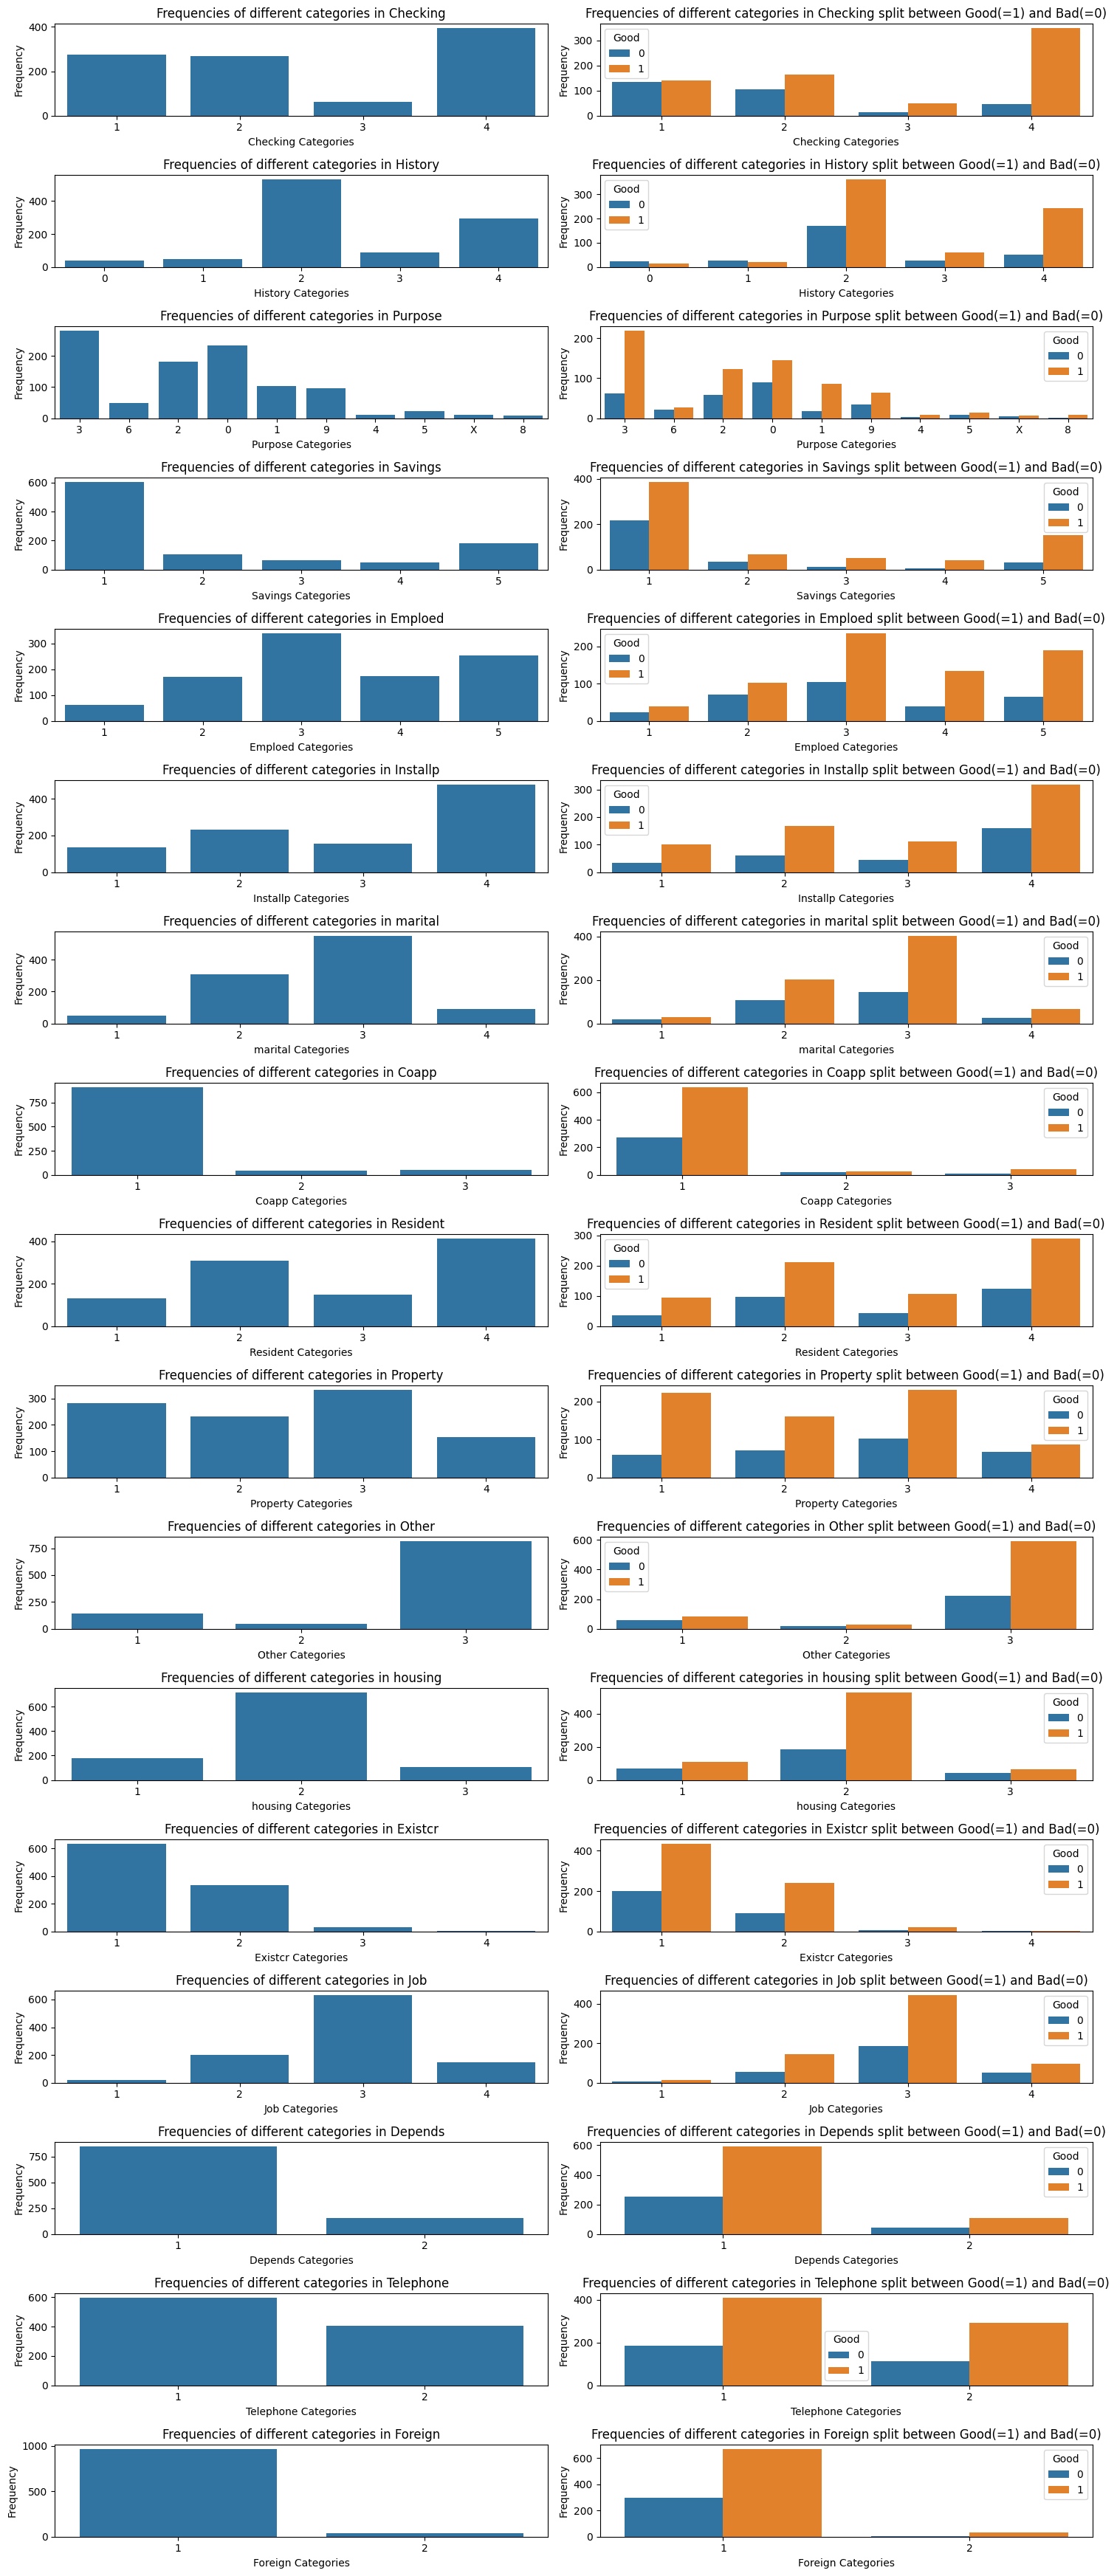

In [13]:
# Side by side plots for easy comparison
plt.figure(figsize=(15, 35))

# Bar plot of frequencies of each category for each categorical variable (without hue)
for i, col in enumerate(categorical_vars):
    plt.subplot(len(categorical_vars), 2, 2*i+1)
    sns.countplot(x=col, data=df)
    plt.xlabel(f'{col} Categories')
    plt.ylabel('Frequency')
    plt.title(f'Frequencies of different categories in {col}')

# Bar plot of frequencies of each category for each categorical variable (with hue)
for i, col in enumerate(categorical_vars):
    plt.subplot(len(categorical_vars), 2, 2*i+2)
    sns.countplot(x=col, data=df, hue='Good')
    plt.xlabel(f'{col} Categories')
    plt.ylabel('Frequency')
    plt.title(f'Frequencies of different categories in {col} split between Good(=1) and Bad(=0)')

plt.tight_layout()
plt.show()


# 1. Split the dataset into two subsets as follows:

- Subset 1: the applicants with Checking = 1 or Checking = 2
- Subset 2: the applicants where Checking = 3 or Checking = 4

Clean the subsets if necessary.

[5 marks]


## Data Cleaning

In the initial EDA above, we can see that the dataframe contains no missing values. However from the output of df.info(), the 'Purpose' has an object dtype and therefore calls for further inspection.

In [14]:
# Check unique categories in 'Pupose' variable

df['Purpose'].unique()

array([3, 6, 2, 0, 1, 9, 4, 5, 'X', 8], dtype=object)

In [15]:
# Percentage of entries of 'Purpose' = 'X' in the total dataframe
(df[df['Purpose'] == 'X'].shape[0] / df.shape[0]) * 100

1.2

As we can see from the result above, Purpose contains a category labelled 'X'. </br> The data dictionary suggests that this should potentially be labelled 7. However 'X' could also mean a missing value.
</br> Because of this lack of information of what the variable 'X' actually means and since it only consists of 1.2% of total entries, I believe it's best that we should drop all rows where the Purpose is 'X'

In [16]:
# Dropping all rows where Purpose = 'X'
df = df[df['Purpose'] != 'X']
# Convert Purpose variable to int dtype
df['Purpose'] = df['Purpose'].astype(int)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 0 to 999
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Checking   988 non-null    int64
 1   Duration   988 non-null    int64
 2   History    988 non-null    int64
 3   Purpose    988 non-null    int64
 4   Amount     988 non-null    int64
 5   Savings    988 non-null    int64
 6   Emploed    988 non-null    int64
 7   Installp   988 non-null    int64
 8   marital    988 non-null    int64
 9   Coapp      988 non-null    int64
 10  Resident   988 non-null    int64
 11  Property   988 non-null    int64
 12  Age        988 non-null    int64
 13  Other      988 non-null    int64
 14  housing    988 non-null    int64
 15  Existcr    988 non-null    int64
 16  Job        988 non-null    int64
 17  Depends    988 non-null    int64
 18  Telephone  988 non-null    int64
 19  Foreign    988 non-null    int64
 20  Good       988 non-null    int64
dtypes: int64(21)
memory u

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,...,Property,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Good
0,1,6,4,3,1169,5,5,4,3,1,...,1,67,3,2,2,3,1,2,1,1
1,2,48,2,3,5951,1,3,2,2,1,...,1,22,3,2,1,3,1,1,1,0
2,4,12,4,6,2096,1,4,2,3,1,...,1,49,3,2,1,2,2,1,1,1
3,1,42,2,2,7882,1,4,2,3,3,...,2,45,3,3,1,3,2,1,1,1
4,1,24,3,0,4870,1,3,3,3,1,...,4,53,3,3,2,3,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,2,1736,1,4,3,2,1,...,1,31,3,2,1,2,1,1,1,1
996,1,30,2,1,3857,1,3,4,1,1,...,2,40,3,2,1,4,1,2,1,1
997,4,12,2,3,804,1,5,4,3,1,...,3,38,3,2,1,3,1,1,1,1
998,1,45,2,3,1845,1,3,4,3,1,...,4,23,3,3,1,3,1,2,1,0


## Splitting according to Checking category

In [17]:
df['Checking'].unique()

array([1, 2, 4, 3])

In [18]:
subset_1 = df[(df['Checking'] == 1) | (df['Checking'] == 2)]
subset_1

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,...,Property,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Good
0,1,6,4,3,1169,5,5,4,3,1,...,1,67,3,2,2,3,1,2,1,1
1,2,48,2,3,5951,1,3,2,2,1,...,1,22,3,2,1,3,1,1,1,0
3,1,42,2,2,7882,1,4,2,3,3,...,2,45,3,3,1,3,2,1,1,1
4,1,24,3,0,4870,1,3,3,3,1,...,4,53,3,3,2,3,2,1,1,0
7,2,36,2,1,6948,1,3,2,3,1,...,3,35,3,1,1,4,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1,18,2,3,1936,5,4,2,4,1,...,3,23,3,1,2,2,1,1,1,1
993,1,36,2,2,3959,1,1,4,3,1,...,2,30,3,2,1,4,1,2,1,1
996,1,30,2,1,3857,1,3,4,1,1,...,2,40,3,2,1,4,1,2,1,1
998,1,45,2,3,1845,1,3,4,3,1,...,4,23,3,3,1,3,1,2,1,0


In [19]:
subset_2 = df[(df['Checking'] == 3) | (df['Checking'] == 4)]
subset_2

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,...,Property,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Good
2,4,12,4,6,2096,1,4,2,3,1,...,1,49,3,2,1,2,2,1,1,1
5,4,36,2,6,9055,5,3,2,3,1,...,4,35,3,3,1,2,2,2,1,1
6,4,24,2,2,2835,3,5,3,3,1,...,2,53,3,2,1,3,1,1,1,1
8,4,12,2,3,3059,4,4,2,1,1,...,1,61,3,2,1,2,1,1,1,1
16,4,24,4,3,2424,5,5,4,3,1,...,2,53,3,2,2,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,4,12,4,6,3565,5,2,2,3,1,...,2,37,3,2,2,2,2,1,1,1
991,4,15,1,3,1569,2,5,4,3,1,...,3,34,1,2,1,2,2,1,1,1
994,4,12,2,0,2390,5,5,4,3,1,...,3,50,3,2,1,3,1,2,1,1
995,4,12,2,2,1736,1,4,3,2,1,...,1,31,3,2,1,2,1,1,1,1


In [20]:
# Double check split is correct

print(f"Subset 1 should only have values 1 and 2 in Checking column. The resulting subset we have has values: {subset_1['Checking'].unique()}.")
print(f"Subset 2 should only have values 3 and 4 in Checking column. The resulting subset we have has values: {subset_2['Checking'].unique()}.")

Subset 1 should only have values 1 and 2 in Checking column. The resulting subset we have has values: [1 2].
Subset 2 should only have values 3 and 4 in Checking column. The resulting subset we have has values: [4 3].


## EDA of splits

### Subset 1

In [21]:
# Histogram and Box Plot for each continuous variable in Subset 1
for feat in continuous_vars:
    histogram_boxplot(subset_1, feat)

In [22]:
# Correlation plot of subset_1
plot_correlation(subset_1)

### Subset 2

In [23]:
# Histogram and Box Plot for each continuous variable in Subset 2
for feat in continuous_vars:
    histogram_boxplot(subset_2, feat)

In [24]:
# Correlation plot of subset_2
plot_correlation(subset_2)

# 2. For each subset, establish a training set and validation set. Explain:
- a.	what principle you have used to decide on these;
- b.	why both training and validation sets are needed;
- c.	any issues encountered during the splitting exercise.

[5 marks]


In [25]:
# Split subset_1 data

subset_1_train, subset_1_test = train_test_split(subset_1, test_size=0.3, stratify=subset_1['Good'], random_state = 42)
subset_1_train

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,...,Property,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Good
99,2,20,3,1,7057,5,4,3,3,1,...,2,36,1,1,2,4,2,2,1,1
330,1,24,4,1,6615,1,1,2,3,1,...,4,75,3,3,2,4,1,2,1,1
186,2,9,1,1,5129,1,5,2,2,1,...,4,74,1,3,1,4,2,2,1,0
319,1,15,3,2,3643,1,5,1,2,1,...,2,27,3,2,2,2,1,1,1,1
735,2,36,1,4,3990,5,2,3,2,1,...,4,29,1,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,2,48,1,9,6416,1,5,4,2,1,...,4,59,3,1,1,3,1,1,1,0
588,1,18,2,4,1217,1,3,4,4,1,...,1,47,3,2,1,2,1,2,1,0
254,2,9,2,2,2030,5,4,2,3,1,...,3,24,3,2,1,3,1,2,1,1
988,1,24,2,1,6579,1,1,4,3,1,...,4,29,3,3,1,4,1,2,1,1


In [26]:
# Check if split is correct

print(subset_1_train['Good'].values.sum(), np.round(subset_1['Good'].values.sum()*0.7))
print(subset_1_test['Good'].values.sum(), np.round(subset_1['Good'].values.sum()*0.3))
print(subset_1['Good'].values.sum(), subset_1_train['Good'].values.sum() + subset_1_test['Good'].values.sum())

# Numbers should be equal

208 208.0
89 89.0
297 297


In [27]:
# Split subset_2 data

subset_2_train, subset_2_test = train_test_split(subset_2, test_size=0.3, stratify=subset_2['Good'], random_state = 42)
subset_2_train

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,...,Property,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Good
45,4,11,4,0,1393,1,2,4,2,1,...,3,35,3,2,2,4,1,1,1,1
512,3,15,2,9,2687,1,4,2,3,1,...,2,26,3,1,1,3,1,2,1,1
379,4,6,4,0,362,2,3,4,2,1,...,3,52,3,2,2,2,1,1,1,1
776,4,36,4,0,3535,1,4,4,3,1,...,3,37,3,2,2,3,1,2,1,1
699,3,15,2,6,1905,1,5,4,3,1,...,3,40,3,1,1,4,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,3,6,2,2,2116,1,3,2,3,1,...,1,41,3,2,1,3,1,2,1,1
283,4,15,4,2,1520,5,5,4,3,1,...,2,63,3,2,1,3,1,1,1,1
217,3,36,2,3,3913,1,3,2,3,1,...,1,23,3,2,1,3,1,2,1,1
81,4,15,2,3,1213,3,5,4,3,1,...,2,47,2,2,1,3,1,2,1,1


In [28]:
# Checks

# print(subset_2_train['Good'].values.sum(), np.round(subset_2['Good'].values.sum()*0.7))
# print(subset_2_test['Good'].values.sum(), np.round(subset_2['Good'].values.sum()*0.3))
# print(subset_2['Good'].values.sum(), subset_2_train['Good'].values.sum() + subset_2_test['Good'].values.sum())

# print(subset_2_train['Good'].values.sum() / len(subset_2_train['Good'].values))
# print(subset_2_test['Good'].values.sum() / len(subset_2_test['Good'].values))
# print(subset_1_train['Good'].values.sum() / len(subset_1_train['Good'].values))
# print(subset_1_test['Good'].values.sum() / len(subset_1_test['Good'].values))

## Deciding Principles & Reasoning:

### a)
- **Split Ratios:** The main thing to note here is that with more training data, the model will have more examples to learn from and hence should lead to better performance. With more testing data, we will achieve more reliable evaluation results [1]. However with a limited dataset, there is a compromise between the amount in each. Typically, the train/test splits are 80/20 or 70/30 [2-3] and I have decided to go for 70/30.

- **Stratification:** It is important to maintain a similar distribution of the target class in the training and test sets which was done by utilising the 'stratify' paramter in sklearn's train_test_split function.

- **Random Sampling:** Ideally, we would like a general model. For instance, if we were to only train the model on certain categories of a specific variable, then it would not be effective when shown the other categories of that variable. Hence, random sampling is important when splitting into training and test sets.

In Python, the train_test_split function from scikit-learn can handle these 3 principles seamlessly.

### b)

Ultimately, after training our model we would like it to be able to predict whether a new customer is going to be 'Good' or 'Bad'. If we train the model on the whole dataset, we would not be able to evaluate it's performance on 'new' customers, hence why it is important to split into training and test sets.


### c)

Initially, I forgot to set the random_state parameter which lead to different splits everytime [4] which caused problems in the later tasks.


**References:**

- [1] - https://datascience.stackexchange.com/questions/17328/statistics-train-and-test-data-split
- [2] - (Wiley and SAS Business Series) Naeem Siddiqi - Intelligent Credit Scoring. (2017).
- [3] - Lyn C. Thomas - Consumer Credit Models. Oxford University Press, USA (2009).
- [4] - https://stackoverflow.com/questions/49147774/what-is-random-state-in-sklearn-model-selection-train-test-split-example

# 3. For each training set choose four variables which are suitable for building a scorecard.

For each training set the variables must have </br>
(i) at least one continuous variable before binning; </br>
(ii) at least one categorical variable with more than two categories, so you can see whether categories can be combined.

Explain the rationale behind your choice of variables (using supporting statistics eg chi- square). Should you be unable to choose variables satisfying the above criteria, explain the problem you have encountered and the solution you have chosen to compromise the variable selection.

[10 marks]


## Approach and Reasoning

I have decided to use the WoE and IV statistics in order to select the four variables.

According to [1], the WoE tells the predictive power of a variable and the IV statistic is useful for selecting important variables with the interpretation of the IV values are as follows [1 - 2]:

- IV < 0.02 - Variable is not useful for prediction
- 0.02 <= IV < 0.1 - Variable has weak predictive power
- 0.1 <= IV < 0.3 - Variable has medium predictive power
- 0.3 <= IV < 0.5 - Variable has strong predictive power
- IV > 0.5 - Variable has suspiciously high predictive power

I have chosen these statistics to select the variables as they made sense to me intuitively. The WoE is essentially the natural log of the percentage of non-events over the percenatge of events so if the percentage of non-events and events are equal in a category/bin, the WoE is 0 which made sense to me as I'd expect that category/bin to not tell me much information on whether an event on non-event will occur.

In order to calculate the WoE, it required binning of continuous variables with sources \[2-3\] suggesting to initially group data into around 10-20 bins and then calculate the WoE (or AdjustedWoE in the case where a particular category/bin contains no events or non-events) and IV. The statistics are calculated with these equations \[1-2\]: </br></br> - WoE = In(% of non-events / % of events) </br> - IV = ∑ (% of non-events - % of events) * WoE </br> - AdjustedWoE = ln (((Number of non-events in a group + 0.5) / Number of non-events)) / ((Number of events in a group + 0.5) / Number of events))</br></br>

However when I intially I appraoched it in this way, I observed more than one variable with suspiciously high predictive power which signalled to me that these variables required further inspection. A potential reason for the significantly large value of the IV may be due to an uneven distribution of events within bins which may be due to sub-optimal binning.

To address the problem of potentially uneven distribution of events in bins, I decided to calculate the IV values using an optimal binning algorithm from the 'OptBinning' library [4].

The main parameter to note is the 'monotonic_trend' parameter. I set it to equal "auto_asc_desc" as this allows us to automatically determine the best monotonic trend of WoE while maximising the IV [4].

By appraoching the problem in this way instead, I was able to select the strongest variables according to their IV's, and find the optimal groupings/binnings.

After calculating the IV values, I then select the variables with the strongest predictive power and the turned them into dummy variables through modelling and adapting the notebook found in [2].

Finally, after converting into dummy variables, I removed one of the dummy variables for each original variable in order to avoid the dummy variable trap [2]. The dummy variable which was removed was the variable which did not fit the trend of the WoE, or it had the lowest WoE, or it had minimal observations.

**References**

[1] - https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html?m=1#what_is_information_value </br>
[2] - https://www.kaggle.com/code/chandrimad31/credit-risk-part-1-binning-woe-iv-pd-model/notebook#Binning,-Weight-of-Evidence-(WoE),-Information-Value-(IV) </br>
[3] - https://www.lancaster.ac.uk/stor-i-student-sites/katie-howgate/2021/02/07/how-to-build-a-credit-scorecard/ </br>
[4] - https://gnpalencia.org/optbinning/index.html </br>


## Subset 2

In [29]:
# Perform optimal binning then calculate IV value of continuous variable
def calc_opt_bin_IV_cont_var(df_train, continuous_vars):
  cont_IVs = []
  for var in continuous_vars:
    x = df_train[var].values
    y = df_train['Good'].values
    optb = OptimalBinning(name=var, dtype="numerical", solver="cp",
                          monotonic_trend = 'auto_asc_desc', min_bin_size = 0.05)
    optb.fit(x, y)
    print(optb.status)
    binning_table = optb.binning_table
    IV_total = binning_table.build()['IV'].values[-1]
    cont_IVs.append(IV_total)
    print(f"{var}: has IV {IV_total}")
  return cont_IVs

In [30]:
# Perform optimal binning then calculate IV value of categorical variable
def calc_opt_bin_IV_cat_var(df_train, categorical_vars):
  cat_IVs = []
  for var in categorical_vars:
    x_cat = df_train[var].values
    y_cat = df_train['Good'].values
    optb = OptimalBinning(name=var, dtype="categorical", solver="mip", cat_cutoff=0.05, monotonic_trend = 'auto_asc_desc')
    optb.fit(x_cat, y_cat)
    print(optb.status)
    binning_table = optb.binning_table
    binning_table.build()
    IV_total = binning_table.build()['IV'].values[-1]
    cat_IVs.append(IV_total)
    print(f"{var}: has IV {IV_total}")
  return cat_IVs

In [31]:
# Code adapted from:
# https://www.kaggle.com/code/lusfernandotorres/weight-of-evidence-and-information-value#woe_and_iv

def interpret_iv(iv_value):
    if iv_value < 0.02:
        return 'Does not appear to be useful for prediction'
    elif iv_value < 0.1:
        return 'Weak predictive power'
    elif iv_value < 0.3:
        return 'Medium predictive power'
    elif iv_value < 0.5:
        return 'Strong predictive power'
    else:
        return 'Suspicious relationship'

In [32]:
subset_2_train_cont_IVs = calc_opt_bin_IV_cont_var(subset_2_train, continuous_vars)

OPTIMAL
Duration: has IV 0.3944187648399663
OPTIMAL
Amount: has IV 0.20993667215578415
OPTIMAL
Age: has IV 0.10301139004964666


In [33]:
subset_2_train_cat_IVs = calc_opt_bin_IV_cat_var(subset_2_train, categorical_vars)

OPTIMAL
Checking: has IV 0.046041026899337104
OPTIMAL
History: has IV 0.09819898663635777
OPTIMAL
Purpose: has IV 0.30288015477185914
OPTIMAL
Savings: has IV 0.03842513321395691
OPTIMAL
Emploed: has IV 0.3509131000067733
OPTIMAL
Installp: has IV 0.09969946332065431
OPTIMAL
marital: has IV 0.13401433198911253
OPTIMAL
Coapp: has IV 0.030474346747217253
OPTIMAL
Resident: has IV 0.006146867749371758
OPTIMAL
Property: has IV 0.04680303581220698
OPTIMAL
Other: has IV 0.28160259845809227
OPTIMAL
housing: has IV 0.1166494330761462
OPTIMAL
Existcr: has IV 0.012092686792266067
OPTIMAL
Job: has IV 0.12431470056286127
OPTIMAL
Depends: has IV 0.0029332198104683104
OPTIMAL
Telephone: has IV 0.01602202819874702
OPTIMAL
Foreign: has IV 0.002621258614202299


In [34]:
# Construct a dictionary from the lists
subset_2_train_IVdata = {'Variable': continuous_vars + categorical_vars, 'IV': subset_2_train_cont_IVs + subset_2_train_cat_IVs}

# Create a DataFrame
subset_2_train_IVdf = pd.DataFrame(subset_2_train_IVdata)

# subset_2_train_IVdf

In [35]:
# Define the predictive power of each characteristic
strength = []

# Assign the rule of thumb regarding IV
for iv in subset_2_train_IVdf['IV']:
  interp = interpret_iv(iv)
  strength.append(interp)

# Assign the strength to each characteristic
subset_2_train_IVdf = subset_2_train_IVdf.assign(Strength = strength)

# Sort the table by the IV values
subset_2_train_IVdf.sort_values(by='IV', ascending=False)

,Variable,IV,Strength
0,Duration,0.394419,Strong predictive power
7,Emploed,0.350913,Strong predictive power
5,Purpose,0.302880,Strong predictive power
13,Other,0.281603,Medium predictive power
1,Amount,0.209937,Medium predictive power
9,marital,0.134014,Medium predictive power
16,Job,0.124315,Medium predictive power
14,housing,0.116649,Medium predictive power
2,Age,0.103011,Medium predictive power
8,Installp,0.099699,Weak predictive power


### Selected Features:

- **Continuous:** Duration
- **Categorical:** Emploed, Purpose, Other

### Optimal Binning

#### Duration

In [36]:
x = subset_2_train['Duration'].values
y = subset_2_train['Good'].values
optb = OptimalBinning(name='Duration', dtype="numerical", solver="cp",
                      monotonic_trend = 'auto_asc_desc', min_bin_size = 0.05)
optb.fit(x, y)
print(optb.status)
binning_table = optb.binning_table
binning_table.build()

OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8.00)",38,0.119122,1,37,0.973684,-1.72457,0.189297,0.021107
1,"[8.00, 14.00)",91,0.285266,7,84,0.923077,-0.598559,0.081753,0.010069
2,"[14.00, 16.50)",25,0.078370,3,22,0.880000,-0.106082,0.000848,0.000106
3,"[16.50, 25.50)",106,0.332288,18,88,0.830189,0.299383,0.033196,0.004134
4,"[25.50, inf)",59,0.184953,13,46,0.779661,0.622656,0.089325,0.010989
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,319,1.000000,42,277,0.868339,,0.394419,0.046405


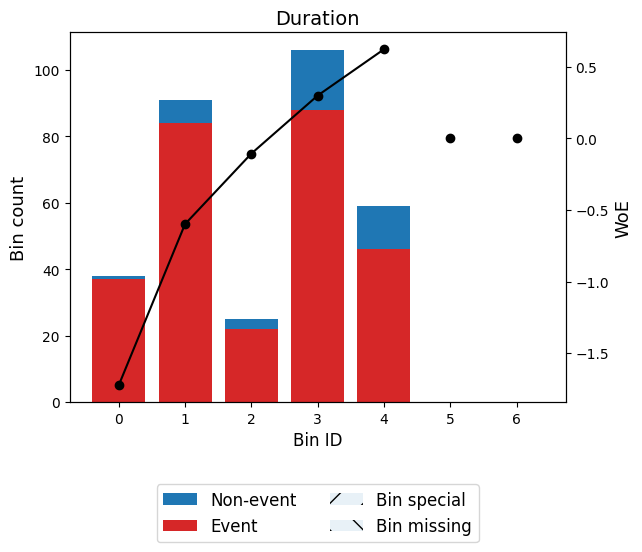

In [37]:
binning_table.plot(metric="woe")

#### Duration binning

In [38]:
list(binning_table.build()['Bin'].values[:-3])

['(-inf, 8.00)',
 '[8.00, 14.00)',
 '[14.00, 16.50)',
 '[16.50, 25.50)',
 '[25.50, inf)']

In [39]:
# Define custom bin edges
subset_2_duration_bin_edges = [-float('inf'), 8, 14, 16.50, 25.50, float('inf')]

# Compute bin indices using np.digitize
subset_2_duration_bin_indices = np.digitize(subset_2_train['Duration'], subset_2_duration_bin_edges) - 1
# print(subset_2_duration_bin_indices)

# Define bin labels
subset_2_duration_bin_labels = list(binning_table.build()['Bin'].values[:-3])
# print(subset_2_duration_bin_labels)

# Map bin indices to bin labels
subset_2_train['Duration_Bin'] = [subset_2_duration_bin_labels[i] for i in subset_2_duration_bin_indices]

In [40]:
# Checks
# subset_2_train[['Duration','Duration_Bin']]

#### Purpose

In [41]:
# Categorical
variable_cat = "Purpose"
x_cat = subset_2_train[variable_cat].values
y_cat = subset_2_train['Good']
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip", cat_cutoff=0.05, monotonic_trend = 'auto_asc_desc')
optb.fit(x_cat, y_cat)
print(optb.status)
binning_table = optb.binning_table
binning_table.build()

OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[6],16,0.050157,4,12,0.750000,0.787736,0.040897,0.004984
1,[9],25,0.078370,6,19,0.760000,0.733668,0.054486,0.006662
2,[2],50,0.156740,9,41,0.820000,0.37,0.024520,0.003048
3,[0],70,0.219436,11,59,0.842857,0.206706,0.010110,0.001261
4,[3],106,0.332288,9,97,0.915094,-0.491139,0.066743,0.008260
5,[1],41,0.128527,2,39,0.951220,-1.084067,0.101008,0.012042
6,"[5, 8, 4]",11,0.034483,1,10,0.909091,-0.416237,0.005116,0.000635
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,319,1.000000,42,277,0.868339,,0.302880,0.036892


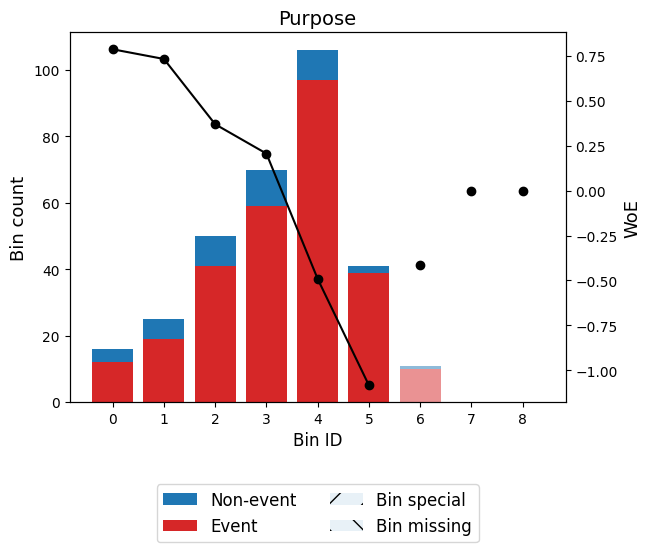

In [42]:
binning_table.plot(metric="woe")

#### Purpose Binning

In [43]:
purpose_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: "[5,8,4]", 5: "[5,8,4]", 6: 6, 7: 7, 8: "[5,8,4]", 9: 9}
subset_2_train['Purpose_Bin'] = subset_2_train['Purpose'].map(purpose_mapping)

In [44]:
# Checks

# subset_2_train[subset_2_train['Purpose'].isin([5,4,8])]
# subset_2_train

#### Emploed

In [45]:
# Categorical
variable_cat = "Emploed"
x_cat = subset_2_train[variable_cat].values
y_cat = subset_2_train['Good']
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip", cat_cutoff=0.05, monotonic_trend = 'auto_asc_desc')
optb.fit(x_cat, y_cat)
print(optb.status)
binning_table = optb.binning_table
binning_table.build()

OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[2],43,0.134796,8,35,0.813953,0.410441,0.026318,0.003267
1,[3],115,0.360502,20,95,0.826087,0.328203,0.043727,0.005441
2,[5],97,0.304075,9,88,0.907216,-0.393764,0.040717,0.005057
3,[4],54,0.169279,2,52,0.962963,-1.371749,0.192191,0.022301
4,[1],10,0.031348,3,7,0.700000,1.03905,0.047960,0.005739
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,319,1.000000,42,277,0.868339,,0.350913,0.041806


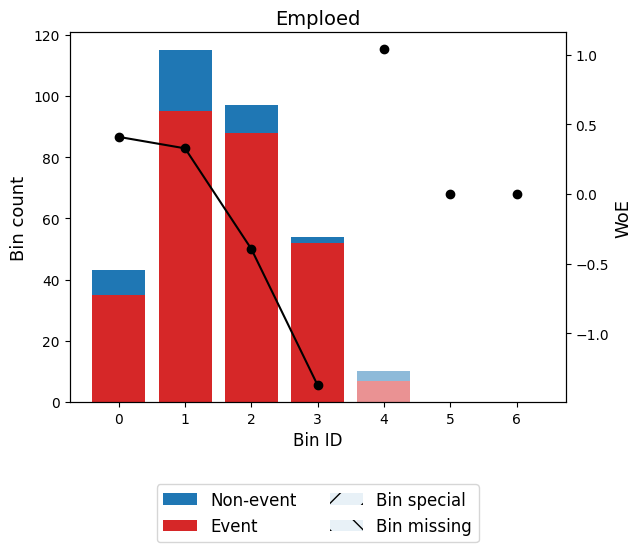

In [46]:
binning_table.plot(metric="woe")

#### No binning required for 'Emploed' variable

#### Other

In [47]:
# Categorical
variable_cat = "Other"
x_cat = subset_2_train[variable_cat].values
y_cat = subset_2_train['Good']
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip", cat_cutoff=0.05, monotonic_trend = 'auto_asc_desc')
optb.fit(x_cat, y_cat)
print(optb.status)
binning_table = optb.binning_table
binning_table.build()

OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[1],38,0.119122,12,26,0.684211,1.113158,0.213561,0.025397
1,[2],17,0.053292,3,14,0.823529,0.345903,0.007225,0.000899
2,[3],264,0.827586,27,237,0.897727,-0.285875,0.060817,0.007576
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,319,1.000000,42,277,0.868339,,0.281603,0.033872


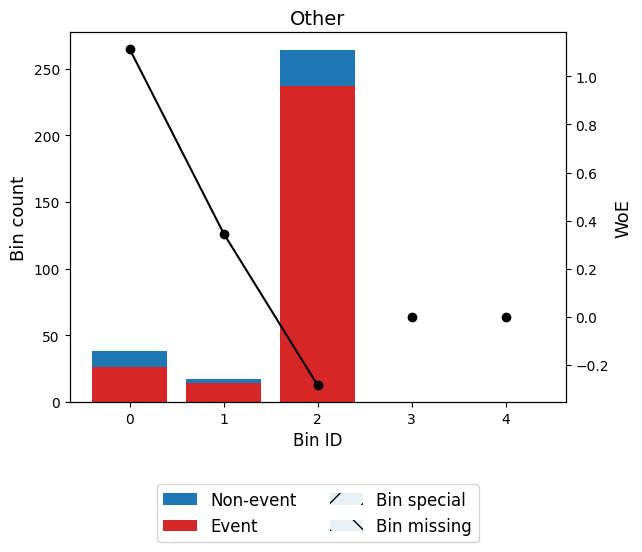

In [48]:
binning_table.plot(metric="woe")

#### No binning required for 'Other' variable

#### Dummy Classifying

In [49]:
columns_to_keep = ['Duration_Bin','Purpose_Bin','Emploed','Other']

subset_2_train_preprocessed = subset_2_train[columns_to_keep]
subset_2_train_preprocessed

,Duration_Bin,Purpose_Bin,Emploed,Other
45,"[8.00, 14.00)",0,2,3
512,"[14.00, 16.50)",9,4,3
379,"(-inf, 8.00)",0,3,3
776,"[25.50, inf)",0,4,3
699,"[14.00, 16.50)",6,5,3
...,...,...,...,...
626,"(-inf, 8.00)",2,3,3
283,"[14.00, 16.50)",2,5,3
217,"[25.50, inf)",3,3,3
81,"[14.00, 16.50)",3,5,2


In [50]:
# dummy variables
data_dummies1 = [pd.get_dummies(subset_2_train_preprocessed['Duration_Bin'], prefix='Duration_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_2_train_preprocessed['Purpose_Bin'], prefix='Purpose_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_2_train_preprocessed['Emploed'], prefix='Emploed_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_2_train_preprocessed['Other'], prefix='Other', prefix_sep=':'),
                ]

In [51]:
# turn  data_dummies into dataframe

subset_2_train_categorical_dummies = pd.concat(data_dummies1, axis=1)
subset_2_train_categorical_dummies.astype(int)

,"Duration_Bin:(-inf, 8.00)","Duration_Bin:[14.00, 16.50)","Duration_Bin:[16.50, 25.50)","Duration_Bin:[25.50, inf)","Duration_Bin:[8.00, 14.00)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,"Purpose_Bin:[5,8,4]",Emploed_Bin:1,Emploed_Bin:2,Emploed_Bin:3,Emploed_Bin:4,Emploed_Bin:5,Other:1,Other:2,Other:3
45,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
512,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
379,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
776,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
699,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
283,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
217,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
81,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


#### Dropping Category

In [52]:
#dummy categories to drop
ref_categories = ['Other:2', 'Emploed_Bin:1', "Purpose_Bin:[5,8,4]",'Duration_Bin:[14.00, 16.50)']
subset_2_train_categorical_dummies.drop(columns=ref_categories, inplace=True, axis=1)

In [53]:
subset_2_train_categorical_dummies = subset_2_train_categorical_dummies.astype(int)

In [54]:
# Include Good column
subset_2_train_categorical_dummies['Good'] = subset_2_train['Good']
subset_2_train_categorical_dummies

,"Duration_Bin:(-inf, 8.00)","Duration_Bin:[16.50, 25.50)","Duration_Bin:[25.50, inf)","Duration_Bin:[8.00, 14.00)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,Emploed_Bin:2,Emploed_Bin:3,Emploed_Bin:4,Emploed_Bin:5,Other:1,Other:3,Good
45,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1
512,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1
379,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
776,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1
699,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1
283,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1
217,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1
81,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


## Subset 1

In [55]:
subset_1_train_cont_IVs = calc_opt_bin_IV_cont_var(subset_1_train,continuous_vars)

OPTIMAL
Duration: has IV 0.2378391492781115
OPTIMAL
Amount: has IV 0.061431277142069446
OPTIMAL
Age: has IV 0.08565424907682051


In [56]:
subset_1_train_cat_IVs = calc_opt_bin_IV_cat_var(subset_1_train, categorical_vars)

OPTIMAL
Checking: has IV 0.011347410405175333
OPTIMAL
History: has IV 0.1983768344508533
OPTIMAL
Purpose: has IV 0.15063937284181483
OPTIMAL
Savings: has IV 0.21546765847840987
OPTIMAL
Emploed: has IV 0.04553530315560435
OPTIMAL
Installp: has IV 0.09615852852509242
OPTIMAL
marital: has IV 0.039085481962169794
OPTIMAL
Coapp: has IV 0.08235465811106979
OPTIMAL
Resident: has IV 0.002890782964164571
OPTIMAL
Property: has IV 0.13174569072946546
OPTIMAL
Other: has IV 0.034123813827576954
OPTIMAL
housing: has IV 0.06470968760663741
OPTIMAL
Existcr: has IV 0.013744353890597978
OPTIMAL
Job: has IV 0.02628613218239891
OPTIMAL
Depends: has IV 0.006803759077291778
OPTIMAL
Telephone: has IV 0.022972341148250065
OPTIMAL
Foreign: has IV 0.08849536095122489


In [57]:
# Construct a dictionary from the lists
subset_1_train_IVdata = {'Variable': continuous_vars + categorical_vars, 'IV': subset_1_train_cont_IVs + subset_1_train_cat_IVs}

# Create a DataFrame
subset_1_train_IVdf = pd.DataFrame(subset_1_train_IVdata)

# subset_1_train_IVdf

In [58]:
# Define the predictive power of each characteristic
strength = []

# Assign the rule of thumb regarding IV
for iv in subset_1_train_IVdf['IV']:
  interp = interpret_iv(iv)
  strength.append(interp)

# Assign the strength to each characteristic
subset_1_train_IVdf = subset_1_train_IVdf.assign(Strength = strength)

# Sort the table by the IV values
subset_1_train_IVdf.sort_values(by='IV', ascending=False)

,Variable,IV,Strength
0,Duration,0.237839,Medium predictive power
6,Savings,0.215468,Medium predictive power
4,History,0.198377,Medium predictive power
5,Purpose,0.150639,Medium predictive power
12,Property,0.131746,Medium predictive power
8,Installp,0.096159,Weak predictive power
19,Foreign,0.088495,Weak predictive power
2,Age,0.085654,Weak predictive power
10,Coapp,0.082355,Weak predictive power
14,housing,0.064710,Weak predictive power


### Selected Features:

- **Continuous:** Duration
- **Categorical:** Savings, History, Purpose

### Optimal Binning

#### Duration

In [59]:
x = subset_1_train['Duration'].values
y = subset_1_train['Good'].values
optb = OptimalBinning(name='Duration', dtype="numerical", solver="cp",
                      monotonic_trend = 'auto_asc_desc', min_bin_size = 0.05)
optb.fit(x, y)
print(optb.status)
binning_table = optb.binning_table
binning_table.build()

OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 11.50)",53,0.142473,13,40,0.754717,-0.886258,0.100182,0.012128
1,"[11.50, 15.50)",96,0.258065,39,57,0.593750,-0.141818,0.005139,0.000642
2,"[15.50, 28.50)",132,0.354839,58,74,0.560606,-0.00595,0.000013,0.000002
3,"[28.50, 43.50)",59,0.158602,31,28,0.474576,0.339454,0.018469,0.002298
4,"[43.50, inf)",32,0.086022,23,9,0.281250,1.175941,0.114037,0.013486
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,372,1.000000,164,208,0.559140,,0.237839,0.028556


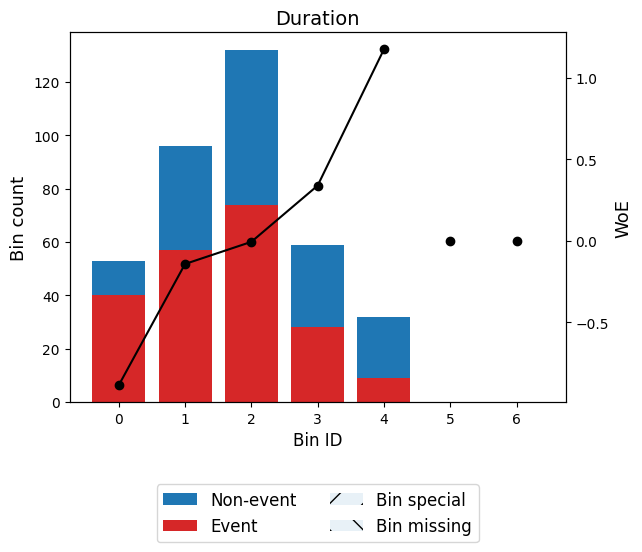

In [60]:
binning_table.plot(metric="woe")

#### Duration binning

In [61]:
list(binning_table.build()['Bin'].values[:-3])

['(-inf, 11.50)',
 '[11.50, 15.50)',
 '[15.50, 28.50)',
 '[28.50, 43.50)',
 '[43.50, inf)']

In [62]:
# Define custom bin edges
subset_1_duration_bin_edges = [-float('inf'), 11.50, 15.50, 28.50, 43.50, float('inf')]

# Compute bin indices using np.digitize
subset_1_duration_bin_indices = np.digitize(subset_1_train['Duration'], subset_1_duration_bin_edges) - 1
# print(subset_1_duration_bin_indices)

# Define bin labels
subset_1_duration_bin_labels = list(binning_table.build()['Bin'].values[:-3])
# print(subset_1_duration_bin_labels)

# Map bin indices to bin labels
subset_1_train['Duration_Bin'] = [subset_1_duration_bin_labels[i] for i in subset_1_duration_bin_indices]

In [63]:
# Checks
# subset_1_train[['Duration','Duration_Bin']]

#### Savings

In [64]:
# Categorical
variable_cat = "Savings"
x_cat = subset_1_train[variable_cat].values
y_cat = subset_1_train['Good']
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip", cat_cutoff=0.05, monotonic_trend = 'auto_asc_desc')
optb.fit(x_cat, y_cat)
print(optb.status)
binning_table = optb.binning_table
binning_table.build()

OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[1],248,0.666667,124,124,0.500000,0.237672,0.038014,0.004741
1,[2],43,0.115591,21,22,0.511628,0.191152,0.004259,0.000532
2,[5],49,0.131720,11,38,0.775510,-1.002019,0.115853,0.013905
3,"[3, 4]",32,0.086022,8,24,0.750000,-0.860941,0.057342,0.006954
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,372,1.000000,164,208,0.559140,,0.215468,0.026131


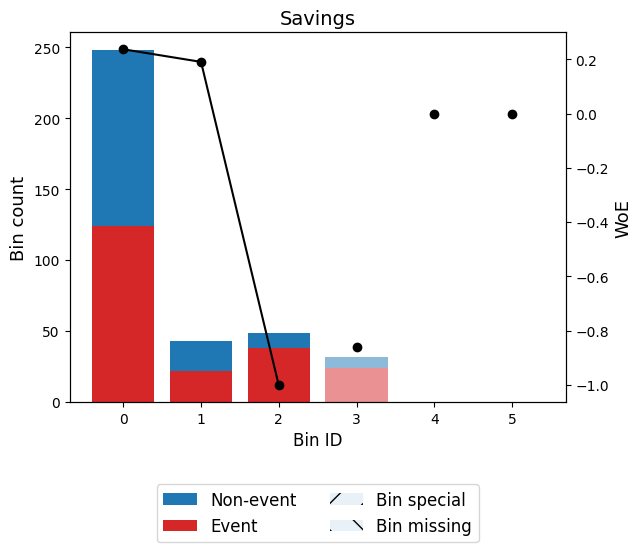

In [65]:
binning_table.plot(metric="woe")

#### Savings binning

In [66]:
savings_mapping = {1: 1, 2: 2, 3: "[3,4]", 4: "[3,4]", 5: 5}
subset_1_train['Savings_Bin'] = subset_1_train['Savings'].map(savings_mapping)

#### History

In [67]:
# Categorical
variable_cat = "History"
x_cat = subset_1_train[variable_cat].values
y_cat = subset_1_train['Good']
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip", cat_cutoff=0.05, monotonic_trend = 'auto_asc_desc')
optb.fit(x_cat, y_cat)
print(optb.status)
binning_table = optb.binning_table
binning_table.build()

OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],23,0.061828,16,7,0.304348,1.06435,0.068020,0.008123
1,[1],25,0.067204,16,9,0.360000,0.813036,0.044141,0.005371
2,[2],206,0.553763,94,112,0.543689,0.062468,0.002168,0.000271
3,[3],32,0.086022,12,20,0.625000,-0.273154,0.006278,0.000782
4,[4],86,0.231183,26,60,0.697674,-0.598576,0.077770,0.009579
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,372,1.000000,164,208,0.559140,,0.198377,0.024125


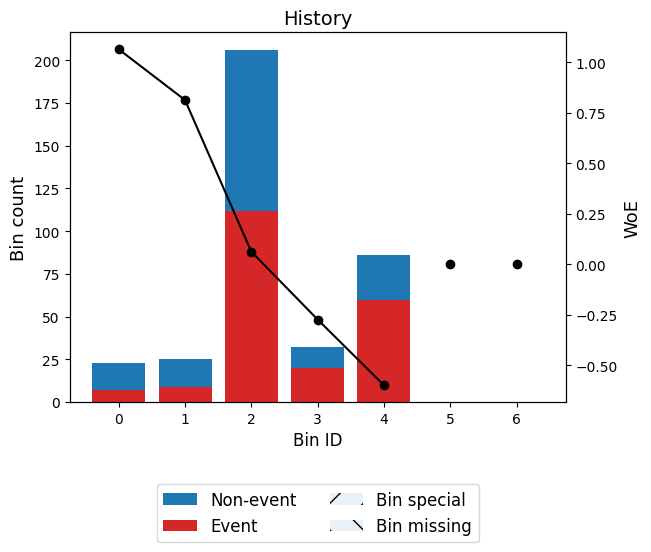

In [68]:
binning_table.plot(metric="woe")

#### No binning required for 'History' variable

#### Purpose

In [69]:
# Categorical
variable_cat = "Purpose"
x_cat = subset_1_train[variable_cat].values
y_cat = subset_1_train['Good']
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip", cat_cutoff=0.05, monotonic_trend = 'auto_asc_desc')
optb.fit(x_cat, y_cat)
print(optb.status)
binning_table = optb.binning_table
binning_table.build()

OPTIMAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[6],23,0.061828,16,7,0.304348,1.06435,0.068020,0.008123
1,[0],88,0.236559,45,43,0.488636,0.283134,0.019157,0.002387
2,[2],80,0.215054,36,44,0.550000,0.037001,0.000295,0.000037
3,[9],39,0.104839,15,24,0.615385,-0.232332,0.005558,0.000693
4,[3],91,0.244624,33,58,0.637363,-0.326264,0.025327,0.003152
5,[1],33,0.088710,10,23,0.696970,-0.595237,0.029525,0.003637
6,"[5, 4, 8]",18,0.048387,9,9,0.500000,0.237672,0.002759,0.000344
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,372,1.000000,164,208,0.559140,,0.150639,0.018372


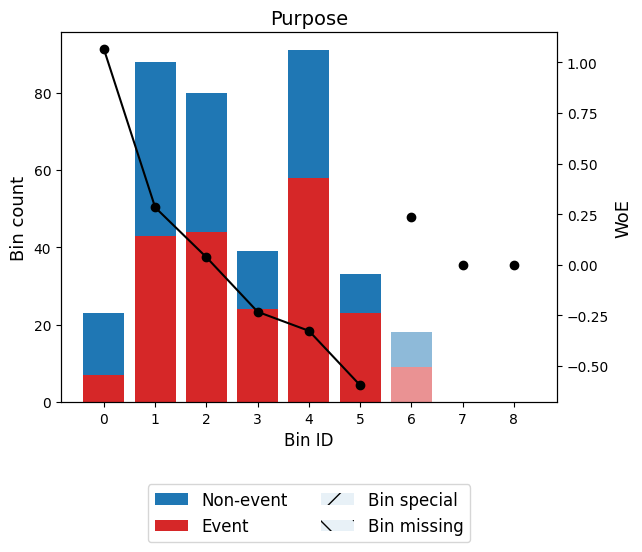

In [70]:
binning_table.plot(metric="woe")

#### Purpose binning

In [71]:
purpose_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: "[5,4,8]", 5: "[5,4,8]", 6: 6, 7: 7, 8: "[5,4,8]", 9: 9}
subset_1_train['Purpose_Bin'] = subset_1_train['Purpose'].map(purpose_mapping)

In [72]:
# Checks

# subset_1_train[subset_1_train['Purpose'].isin([5,4,8])]
# subset_1_train

#### Dummy Classifying

In [73]:
columns_to_keep = ['Duration_Bin','Purpose_Bin','Savings_Bin','History']

subset_1_train_preprocessed = subset_1_train[columns_to_keep]
subset_1_train_preprocessed

,Duration_Bin,Purpose_Bin,Savings_Bin,History
99,"[15.50, 28.50)",1,5,3
330,"[15.50, 28.50)",1,1,4
186,"(-inf, 11.50)",1,1,1
319,"[11.50, 15.50)",2,1,3
735,"[28.50, 43.50)","[5,4,8]",5,1
...,...,...,...,...
728,"[43.50, inf)",9,1,1
588,"[15.50, 28.50)","[5,4,8]",1,2
254,"(-inf, 11.50)",2,5,2
988,"[15.50, 28.50)",1,1,2


In [74]:
# dummy variables
data_dummies1 = [pd.get_dummies(subset_1_train_preprocessed['Duration_Bin'], prefix='Duration_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_1_train_preprocessed['Purpose_Bin'], prefix='Purpose_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_1_train_preprocessed['History'], prefix='History', prefix_sep=':'),
                 pd.get_dummies(subset_1_train_preprocessed['Savings_Bin'], prefix='Savings_Bin', prefix_sep=':'),
                ]

In [75]:
# turn  data_dummies into dataframe

subset_1_train_categorical_dummies = pd.concat(data_dummies1, axis=1)
subset_1_train_categorical_dummies.astype(int)

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)","Duration_Bin:[43.50, inf)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,...,"Purpose_Bin:[5,4,8]",History:0,History:1,History:2,History:3,History:4,Savings_Bin:1,Savings_Bin:2,Savings_Bin:5,"Savings_Bin:[3,4]"
99,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
330,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
186,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
319,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
735,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
588,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
254,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
988,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


#### Dropping Category

In [76]:
#dummy categories to drop
ref_categories = ['Savings_Bin:[3,4]', 'History:0', "Purpose_Bin:[5,4,8]",'Duration_Bin:[43.50, inf)']
subset_1_train_categorical_dummies.drop(columns=ref_categories, inplace=True, axis=1)

In [77]:
subset_1_train_categorical_dummies = subset_1_train_categorical_dummies.astype(int)
subset_1_train_categorical_dummies

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,History:1,History:2,History:3,History:4,Savings_Bin:1,Savings_Bin:2,Savings_Bin:5
99,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1
330,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0
186,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
319,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
735,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
588,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
254,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
988,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [78]:
# Include Good column
subset_1_train_categorical_dummies['Good'] = subset_1_train['Good']
subset_1_train_categorical_dummies

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,History:1,History:2,History:3,History:4,Savings_Bin:1,Savings_Bin:2,Savings_Bin:5,Good
99,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
330,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1
186,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
319,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1
735,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
588,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
254,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1
988,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1


# 4.	Use the binary variables obtained from the coarse classification in the above exercise to build two scorecards for each training set, one using linear regression, the other using logistic regression.

Note this means you should have four scorecards in total:

(i)	using linear regression for Checking = 1 or 2;</br>
(ii)	using logistic regression for Checking = 1 or 2;</br>
(iii)	using linear regression for Checking = 3 or 4;</br>
(iv)	using logistic regression for Checking = 3 or 4;

*Note that the file you submit should include, in the Appendix, a table that gives the binary variables you used, together with the coefficients for those variables calculated in each regression.*

[15 marks]


## Subset 2

### Linear Regression

In [79]:
# subset_2_train_categorical_dummies

In [80]:
# Preparing the data for linear regression
X_train = subset_2_train_categorical_dummies.drop('Good', axis=1)  # Features
# y = subset_2_train['Good']  # Target variable
y_train = subset_2_train_categorical_dummies['Good']  # Target variable

In [81]:
X_train

,"Duration_Bin:(-inf, 8.00)","Duration_Bin:[16.50, 25.50)","Duration_Bin:[25.50, inf)","Duration_Bin:[8.00, 14.00)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,Emploed_Bin:2,Emploed_Bin:3,Emploed_Bin:4,Emploed_Bin:5,Other:1,Other:3
45,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
512,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
379,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
776,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
699,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
283,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
217,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
81,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [82]:
# Adding a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)

# Creating the model
subset_2_lin_reg_model = sm.OLS(y_train, X_train_const)

# Fitting the model
subset_2_lin_reg_results = subset_2_lin_reg_model.fit()

# Printing the summary of the model
print(subset_2_lin_reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Good   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     3.367
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.77e-05
Time:                        12:52:57   Log-Likelihood:                -80.552
No. Observations:                 319   AIC:                             195.1
Df Residuals:                     302   BIC:                             259.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [83]:
# Extract the regression coefficients
params = subset_2_lin_reg_results.params

# Create a DataFrame with variable names and corresponding coefficients
coefficients_df = pd.DataFrame({'Variable': params.index, 'Coefficient': params.values})

coefficients_df

,Variable,Coefficient
0,const,0.713665
1,"Duration_Bin:(-inf, 8.00)",0.111844
2,"Duration_Bin:[16.50, 25.50)",-0.049473
3,"Duration_Bin:[25.50, inf)",-0.111127
4,"Duration_Bin:[8.00, 14.00)",0.073100
5,Purpose_Bin:0,-0.048133
6,Purpose_Bin:1,0.104090
7,Purpose_Bin:2,-0.060443
8,Purpose_Bin:3,0.022537
9,Purpose_Bin:6,-0.184630


#### Resulting Scorecard

In [84]:
subset_2_lin_reg_coefficients = coefficients_df['Coefficient'].values[1:]
# Scale the coefficients by multiplying by 100 and rounding
subset_2_lin_reg_scaled_coefficients = np.round(subset_2_lin_reg_coefficients * 100)

subset_2_lin_reg_intercept = coefficients_df['Coefficient'].values[0]
# The score is calculated as the dot product of the coefficients and the features plus the intercept
# The intercept also needs to be scaled
subset_2_lin_reg_scaled_intercept = np.round(subset_2_lin_reg_intercept * 100)

# Calculating the score for each row in the dataset
lin_reg_subset_2_train_categorical_dummies = subset_2_train_categorical_dummies.copy()
lin_reg_subset_2_train_categorical_dummies['Score_Regression'] = (X_train.dot(subset_2_lin_reg_scaled_coefficients) + subset_2_lin_reg_scaled_intercept).astype(int)

# Displaying the first few rows of the dataset with the calculated scores
lin_reg_subset_2_train_categorical_dummies

,"Duration_Bin:(-inf, 8.00)","Duration_Bin:[16.50, 25.50)","Duration_Bin:[25.50, inf)","Duration_Bin:[8.00, 14.00)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,Emploed_Bin:2,Emploed_Bin:3,Emploed_Bin:4,Emploed_Bin:5,Other:1,Other:3,Good,Score_Regression
45,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,88
512,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,92
379,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,91
776,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,84
699,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,90
283,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,89
217,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,76
81,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,96


In [85]:
# Check range of score
score_range = lin_reg_subset_2_train_categorical_dummies['Score_Regression'].max() - lin_reg_subset_2_train_categorical_dummies['Score_Regression'].min()
min_score = lin_reg_subset_2_train_categorical_dummies['Score_Regression'].min()
max_score = lin_reg_subset_2_train_categorical_dummies['Score_Regression'].max()

score_range, min_score, max_score

(70, 47, 117)

In [86]:
# lin_reg_subset_2_train_categorical_dummies

### Logistic Regression

In [87]:
# subset_2_train_categorical_dummies

In [88]:
# # Preparing the data for linear regression
# X = subset_2_train_categorical_dummies  # Features
# # y = subset_2_train['Good']  # Target variable
# y = subset_2_train['Good']  # Target variable

In [89]:
# Creating Logistic Regression Model

# Adding a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)
# Creating the model
subset_2_log_reg_model = sm.Logit(y_train, X_train_const)

subset_2_log_reg_results = subset_2_log_reg_model.fit() # Fitting model to the training data

# Priting results
print(subset_2_log_reg_results.summary())

Optimization terminated successfully.
         Current function value: 0.307295
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   Good   No. Observations:                  319
Model:                          Logit   Df Residuals:                      302
Method:                           MLE   Df Model:                           16
Date:                Wed, 01 May 2024   Pseudo R-squ.:                  0.2111
Time:                        12:52:57   Log-Likelihood:                -98.027
converged:                       True   LL-Null:                       -124.26
Covariance Type:            nonrobust   LLR p-value:                 9.203e-06
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.9929      1.747      0.568      0.570   

In [90]:
# Extract the regression coefficients
params = subset_2_log_reg_results.params

# Create a DataFrame with variable names and corresponding coefficients
coefficients_df = pd.DataFrame({'Variable': params.index, 'Coefficient': params.values})

coefficients_df

,Variable,Coefficient
0,const,0.992865
1,"Duration_Bin:(-inf, 8.00)",2.063432
2,"Duration_Bin:[16.50, 25.50)",-0.501790
3,"Duration_Bin:[25.50, inf)",-0.974103
4,"Duration_Bin:[8.00, 14.00)",0.891412
5,Purpose_Bin:0,-0.615317
6,Purpose_Bin:1,1.543605
7,Purpose_Bin:2,-0.654779
8,Purpose_Bin:3,0.202636
9,Purpose_Bin:6,-1.689426


In [91]:
# probabilities of the positive class for the ROC curve function
y_train_pred_prob = subset_2_log_reg_results.predict(X_train_const)
y_train_pred_prob

45     0.920105
512    0.974724
379    0.968559
776    0.927167
699    0.802788
         ...   
626    0.967334
283    0.919713
217    0.769962
81     0.963019
582    0.901695
Length: 319, dtype: float64

In [92]:
# calculate factor and offset
factor = round(20 / np.log(2), 2)
offset = round(600 - factor * np.log(50), 2)

factor, offset

(28.85, 487.14)

#### Resulting Scorecard

In [93]:
# Calculating the score for each row in the dataset
log_reg_subset_2_train_categorical_dummies = subset_2_train_categorical_dummies.copy()
log_reg_subset_2_train_categorical_dummies['P_1'] = y_train_pred_prob
log_reg_subset_2_train_categorical_dummies['P_0'] = 1 - y_train_pred_prob
log_reg_subset_2_train_categorical_dummies['score_obs_prob'] = np.ceil(np.log(log_reg_subset_2_train_categorical_dummies['P_1'] / log_reg_subset_2_train_categorical_dummies['P_0']) * factor + offset)
log_reg_subset_2_train_categorical_dummies

,"Duration_Bin:(-inf, 8.00)","Duration_Bin:[16.50, 25.50)","Duration_Bin:[25.50, inf)","Duration_Bin:[8.00, 14.00)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,Emploed_Bin:2,Emploed_Bin:3,Emploed_Bin:4,Emploed_Bin:5,Other:1,Other:3,Good,P_1,P_0,score_obs_prob
45,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0.920105,0.079895,558.0
512,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0.974724,0.025276,593.0
379,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0.968559,0.031441,587.0
776,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0.927167,0.072833,561.0
699,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0.802788,0.197212,528.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0.967334,0.032666,585.0
283,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0.919713,0.080287,558.0
217,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0.769962,0.230038,522.0
81,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0.963019,0.036981,582.0


In [94]:
# Check range of score
score_range = log_reg_subset_2_train_categorical_dummies['score_obs_prob'].max() - log_reg_subset_2_train_categorical_dummies['score_obs_prob'].min()
min_score = log_reg_subset_2_train_categorical_dummies['score_obs_prob'].min()
max_score = log_reg_subset_2_train_categorical_dummies['score_obs_prob'].max()

score_range, min_score, max_score

(223.0, 454.0, 677.0)

## Subset 1

### Linear Regression

In [95]:
# Preparing the data for linear regression
X_train = subset_1_train_categorical_dummies.drop('Good', axis=1)  # Features
# y = subset_2_train['Good']  # Target variable
y_train = subset_1_train_categorical_dummies['Good']  # Target variable

In [96]:
# Adding a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)

# Creating the model
subset_1_lin_reg_model = sm.OLS(y_train, X_train_const)

# Fitting the model
subset_1_lin_reg_results = subset_1_lin_reg_model.fit()

# Printing the summary of the model
print(subset_1_lin_reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Good   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     4.847
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.28e-09
Time:                        12:52:58   Log-Likelihood:                -228.45
No. Observations:                 372   AIC:                             492.9
Df Residuals:                     354   BIC:                             563.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [97]:
# Extract the regression coefficients
params = subset_1_lin_reg_results.params

# Create a DataFrame with variable names and corresponding coefficients
coefficients_df = pd.DataFrame({'Variable': params.index, 'Coefficient': params.values})

coefficients_df

# Extract the regression coefficients
params = subset_1_lin_reg_results.params

# Create a DataFrame with variable names and corresponding coefficients
coefficients_df = pd.DataFrame({'Variable': params.index, 'Coefficient': params.values})

coefficients_df

,Variable,Coefficient
0,const,0.131554
1,"Duration_Bin:(-inf, 11.50)",0.485659
2,"Duration_Bin:[11.50, 15.50)",0.335560
3,"Duration_Bin:[15.50, 28.50)",0.261206
4,"Duration_Bin:[28.50, 43.50)",0.175768
5,Purpose_Bin:0,-0.022525
6,Purpose_Bin:1,0.238274
7,Purpose_Bin:2,0.072820
8,Purpose_Bin:3,0.134565
9,Purpose_Bin:6,-0.205773


#### Resulting Scorecard

In [98]:
subset_1_lin_reg_coefficients = coefficients_df['Coefficient'].values[1:]
# Scale the coefficients by multiplying by 100 and rounding
subset_1_lin_reg_scaled_coefficients = np.round(subset_1_lin_reg_coefficients * 100)

subset_1_lin_reg_intercept = coefficients_df['Coefficient'].values[0]
# The score is calculated as the dot product of the coefficients and the features plus the intercept
# The intercept also needs to be scaled
subset_1_lin_reg_scaled_intercept = np.round(subset_1_lin_reg_intercept * 100)

# Calculating the score for each row in the dataset
lin_reg_subset_1_train_categorical_dummies = subset_1_train_categorical_dummies.copy()
lin_reg_subset_1_train_categorical_dummies['Score_Regression'] = (X_train.dot(subset_1_lin_reg_scaled_coefficients) + subset_1_lin_reg_scaled_intercept).astype(int)

# Displaying the first few rows of the dataset with the calculated scores
lin_reg_subset_1_train_categorical_dummies

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,History:1,History:2,History:3,History:4,Savings_Bin:1,Savings_Bin:2,Savings_Bin:5,Good,Score_Regression
99,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,104
330,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,80
186,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,70
319,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,65
735,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,17
588,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,38
254,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,98
988,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,62


In [99]:
# Check range of score
score_range = lin_reg_subset_1_train_categorical_dummies['Score_Regression'].max() - lin_reg_subset_1_train_categorical_dummies['Score_Regression'].min()
min_score = lin_reg_subset_1_train_categorical_dummies['Score_Regression'].min()
max_score = lin_reg_subset_1_train_categorical_dummies['Score_Regression'].max()

score_range, min_score, max_score

(131, -9, 122)

In [100]:
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

### Logistic Regression

In [101]:
# Creating Logistic Regression Model

# Adding a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)
# Creating the model
subset_1_log_reg_model = sm.Logit(y_train, X_train_const)

subset_1_log_reg_results = subset_1_log_reg_model.fit() # Fitting model to the training data

# Priting results
print(subset_1_log_reg_results.summary())

Optimization terminated successfully.
         Current function value: 0.581035
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Good   No. Observations:                  372
Model:                          Logit   Df Residuals:                      354
Method:                           MLE   Df Model:                           17
Date:                Wed, 01 May 2024   Pseudo R-squ.:                  0.1532
Time:                        12:52:58   Log-Likelihood:                -216.15
converged:                       True   LL-Null:                       -255.24
Covariance Type:            nonrobust   LLR p-value:                 8.010e-10
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.7466      0.951     -1.837      0.066   

In [102]:
# Extract the regression coefficients
params = subset_1_log_reg_results.params

# Create a DataFrame with variable names and corresponding coefficients
coefficients_df = pd.DataFrame({'Variable': params.index, 'Coefficient': params.values})

coefficients_df

,Variable,Coefficient
0,const,-1.746561
1,"Duration_Bin:(-inf, 11.50)",2.480403
2,"Duration_Bin:[11.50, 15.50)",1.682266
3,"Duration_Bin:[15.50, 28.50)",1.334492
4,"Duration_Bin:[28.50, 43.50)",0.910526
5,Purpose_Bin:0,-0.112399
6,Purpose_Bin:1,1.186001
7,Purpose_Bin:2,0.338703
8,Purpose_Bin:3,0.633932
9,Purpose_Bin:6,-1.080783


In [103]:
# probabilities of the positive class for the ROC curve function
y_train_pred_prob = subset_1_log_reg_results.predict(X_train_const)
y_train_pred_prob

99     0.943952
330    0.814612
186    0.745372
319    0.659712
735    0.495133
         ...   
728    0.162100
588    0.353796
254    0.927207
988    0.641897
261    0.507884
Length: 372, dtype: float64

In [104]:
# calculate factor and offset
factor = round(20 / np.log(2), 2)
offset = round(600 - factor * np.log(50), 2)

factor, offset

(28.85, 487.14)

#### Resulting Scorecard

In [105]:
# Calculating the score for each row in the dataset
log_reg_subset_1_train_categorical_dummies = subset_1_train_categorical_dummies.copy()
log_reg_subset_1_train_categorical_dummies['P_1'] = y_train_pred_prob
log_reg_subset_1_train_categorical_dummies['P_0'] = 1 - y_train_pred_prob
log_reg_subset_1_train_categorical_dummies['score_obs_prob'] = np.ceil(np.log(log_reg_subset_1_train_categorical_dummies['P_1'] / log_reg_subset_1_train_categorical_dummies['P_0']) * factor + offset)
log_reg_subset_1_train_categorical_dummies

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,...,History:2,History:3,History:4,Savings_Bin:1,Savings_Bin:2,Savings_Bin:5,Good,P_1,P_0,score_obs_prob
99,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0.943952,0.056048,569.0
330,0,0,1,0,0,1,0,0,0,0,...,0,0,1,1,0,0,1,0.814612,0.185388,530.0
186,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0.745372,0.254628,519.0
319,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0.659712,0.340288,507.0
735,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.495133,0.504867,487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0.162100,0.837900,440.0
588,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0.353796,0.646204,470.0
254,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0.927207,0.072793,561.0
988,0,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0.641897,0.358103,504.0


In [106]:
# Check range of score
score_range = log_reg_subset_1_train_categorical_dummies['score_obs_prob'].max() - log_reg_subset_1_train_categorical_dummies['score_obs_prob'].min()
min_score = log_reg_subset_1_train_categorical_dummies['score_obs_prob'].min()
max_score = log_reg_subset_1_train_categorical_dummies['score_obs_prob'].max()

score_range, min_score, max_score

(194.0, 401.0, 595.0)

# 5.	Derive ROC curves for all scorecards using the validation set applicable to each, showing in detail how sensitivity and specificity have been calculated. Estimate the Gini coefficient and KS values for each. Explain and comment on your results.

[15 marks]


## Subset 2

### Pre-process testing data

#### Binning

In [107]:
# Define custom bin edges
subset_2_duration_bin_edges = [-float('inf'), 8, 14, 16.50, 25.50, float('inf')]

# Compute bin indices using np.digitize
subset_2_duration_bin_indices = np.digitize(subset_2_test['Duration'], subset_2_duration_bin_edges) - 1
# print(subset_2_duration_bin_indices)

# Map bin indices to bin labels
subset_2_test['Duration_Bin'] = [subset_2_duration_bin_labels[i] for i in subset_2_duration_bin_indices]
subset_2_test

,Checking,Duration,History,Purpose,Amount,Savings,Emploed,Installp,marital,Coapp,...,Age,Other,housing,Existcr,Job,Depends,Telephone,Foreign,Good,Duration_Bin
670,4,24,4,9,4139,2,3,3,3,1,...,27,3,2,2,2,1,2,1,1,"[16.50, 25.50)"
867,4,12,4,2,3331,1,5,2,3,1,...,42,2,2,1,3,1,1,1,1,"[8.00, 14.00)"
16,4,24,4,3,2424,5,5,4,3,1,...,53,3,2,2,3,1,1,1,1,"[16.50, 25.50)"
426,4,28,4,3,2743,1,5,4,3,1,...,29,3,2,2,3,1,1,1,1,"[25.50, inf)"
520,4,24,4,5,5507,1,5,3,3,1,...,44,3,3,2,3,1,1,1,1,"[16.50, 25.50)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,4,15,2,0,3186,4,4,2,2,1,...,20,3,1,1,3,1,1,1,1,"[14.00, 16.50)"
464,4,18,2,9,1950,1,4,4,3,1,...,34,2,2,2,3,1,2,1,1,"[16.50, 25.50)"
527,4,4,4,3,1503,1,4,2,3,1,...,42,3,2,2,2,2,1,1,1,"(-inf, 8.00)"
664,3,6,4,6,1047,1,3,2,2,1,...,50,3,2,1,2,1,1,1,1,"(-inf, 8.00)"


In [108]:
purpose_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: "[5,8,4]", 5: "[5,8,4]", 6: 6, 7: 7, 8: "[5,8,4]", 9: 9}
subset_2_test['Purpose_Bin'] = subset_2_test['Purpose'].map(purpose_mapping)
# subset_2_test[subset_2_test['Purpose'].isin([5,4,8])]

#### Dummy Classifying

In [109]:
columns_to_keep = ['Duration_Bin','Purpose_Bin','Emploed','Other']

subset_2_test_preprocessed = subset_2_test[columns_to_keep]
subset_2_test_preprocessed

,Duration_Bin,Purpose_Bin,Emploed,Other
670,"[16.50, 25.50)",9,3,3
867,"[8.00, 14.00)",2,5,2
16,"[16.50, 25.50)",3,5,3
426,"[25.50, inf)",3,5,3
520,"[16.50, 25.50)","[5,8,4]",5,3
...,...,...,...,...
420,"[14.00, 16.50)",0,4,3
464,"[16.50, 25.50)",9,4,2
527,"(-inf, 8.00)",3,4,3
664,"(-inf, 8.00)",6,3,3


In [110]:
# turn  data_dummies into dataframe
# dummy variables
data_dummies1 = [pd.get_dummies(subset_2_test_preprocessed['Duration_Bin'], prefix='Duration_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_2_test_preprocessed['Purpose_Bin'], prefix='Purpose_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_2_test_preprocessed['Emploed'], prefix='Emploed_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_2_test_preprocessed['Other'], prefix='Other', prefix_sep=':'),
                ]
subset_2_test_categorical_dummies = pd.concat(data_dummies1, axis=1)
subset_2_test_categorical_dummies.astype(int)

,"Duration_Bin:(-inf, 8.00)","Duration_Bin:[14.00, 16.50)","Duration_Bin:[16.50, 25.50)","Duration_Bin:[25.50, inf)","Duration_Bin:[8.00, 14.00)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,"Purpose_Bin:[5,8,4]",Emploed_Bin:1,Emploed_Bin:2,Emploed_Bin:3,Emploed_Bin:4,Emploed_Bin:5,Other:1,Other:2,Other:3
670,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
867,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
16,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
426,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
520,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
464,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
527,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
664,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


#### Dropping Category

In [111]:
#dummy categories to drop
ref_categories = ['Other:2', 'Emploed_Bin:1', "Purpose_Bin:[5,8,4]",'Duration_Bin:[14.00, 16.50)']
subset_2_test_categorical_dummies.drop(columns=ref_categories, inplace=True, axis=1)

In [112]:
subset_2_test_categorical_dummies = subset_2_test_categorical_dummies.astype(int)
subset_2_test_categorical_dummies['Good'] = subset_2_test['Good']
subset_2_test_categorical_dummies

,"Duration_Bin:(-inf, 8.00)","Duration_Bin:[16.50, 25.50)","Duration_Bin:[25.50, inf)","Duration_Bin:[8.00, 14.00)",Purpose_Bin:0,Purpose_Bin:1,Purpose_Bin:2,Purpose_Bin:3,Purpose_Bin:6,Purpose_Bin:9,Emploed_Bin:2,Emploed_Bin:3,Emploed_Bin:4,Emploed_Bin:5,Other:1,Other:3,Good
670,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1
867,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1
16,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1
426,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1
520,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1
464,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
527,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1
664,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1


### Logistic Regression Model

#### ROC

In [113]:
# Preparing the data for linear regression
X_test = subset_2_test_categorical_dummies.drop('Good', axis=1)  # Features
# y = subset_2_train['Good']  # Target variable
y_test = subset_2_test_categorical_dummies['Good']  # Target variable

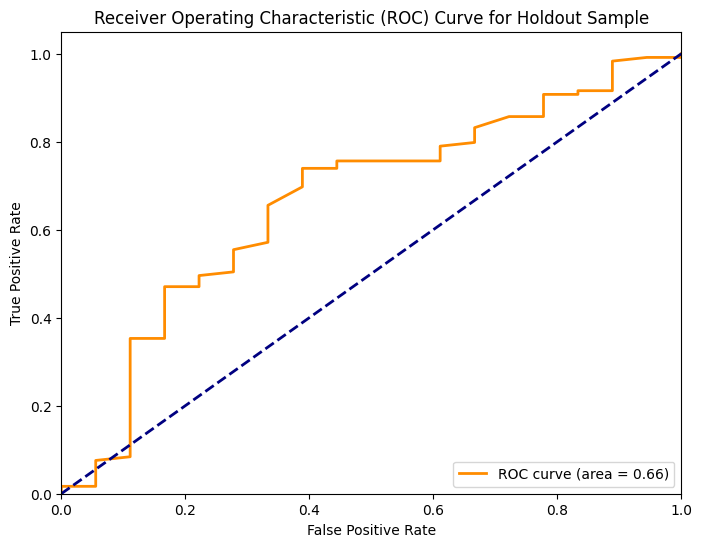

In [114]:
# We need to add a constant to the holdout data for the prediction
X_test_const = sm.add_constant(X_test)

# Predict probabilities for the positive class (1) for the holdout set using the trained model
y_test_pred_prob = subset_2_log_reg_results.predict(X_test_const)

# Compute ROC curve and ROC area for the holdout set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for the holdout set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Holdout Sample')
plt.legend(loc="lower right")
plt.show()

#### AUROC

In [115]:
# Calculate the AUC (Area under the ROC Curve) which is equivalent to Somers' D
roc_auc = auc(fpr_test, tpr_test)
roc_auc

0.6647992530345471

#### Gini coefficient

In [116]:
Gini = roc_auc * 2 - 1
Gini

0.32959850606909424

#### Confusion Matrix, Sensitivity, Specificity.

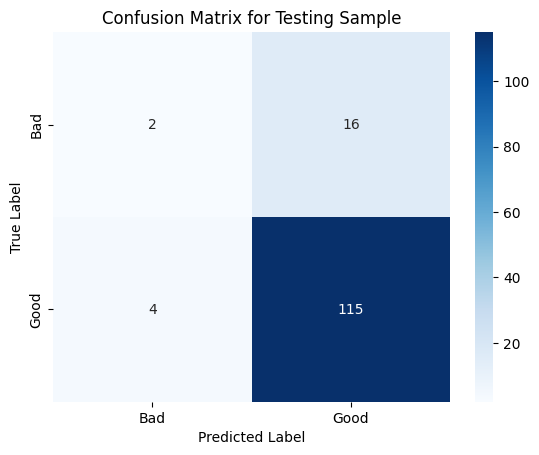

In [117]:
# Assuming 0.5 is the threshold, convert predicted probabilities to class labels based on a 0.5 threshold
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using seaborn for better visualization
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Testing Sample')
plt.show()

In [118]:
# Extract values from the confusion matrix
TN, FP, FN, TP = conf_matrix_test.ravel()

# Calculate Sensitivity (True Positive Rate)
sensitivity = TP / (TP + FN)

# Calculate Specificity (True Negative Rate)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.9663865546218487
Specificity: 0.1111111111111111


#### KS statistic

In [119]:
# Code adapted from:
# https://www.listendata.com/2019/07/KS-Statistics-Python.html

def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    # print(kstable)

    #Display KS
    # from colorama import Fore
    # print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [120]:
# Create dataframne to be used in KS function
# Construct a dictionary from the lists
log_reg_subset_2_test_KS = {'Predicted': y_test_pred_prob, 'True': y_test.values}
# Create a DataFrame
log_reg_subset_2_test_KSdf = pd.DataFrame(log_reg_subset_2_test_KS)

log_reg_subset_2_test_KSdf

,Predicted,True
670,0.730411,1
867,0.964211,1
16,0.942355,1
426,0.910664,1
520,0.930309,1
...,...,...
420,0.971197,1
464,0.957480,1
527,0.998340,1
664,0.913218,1


In [121]:
ks_df = ks(data=log_reg_subset_2_test_KSdf,target="True", prob="Predicted")
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.987985,0.998340,10,2,8.40%,11.11%,8.40%,11.11%,-2.7
2,0.974980,0.987507,16,0,13.45%,0.00%,21.85%,11.11%,10.7
3,0.966732,0.973809,11,0,9.24%,0.00%,31.09%,11.11%,20.0
4,0.951516,0.966493,14,1,11.76%,5.56%,42.86%,16.67%,26.2
5,0.913218,0.942355,11,2,9.24%,11.11%,52.10%,27.78%,24.3
6,0.878268,0.910664,14,1,11.76%,5.56%,63.87%,33.33%,30.5
7,0.841027,0.873986,12,2,10.08%,11.11%,73.95%,44.44%,29.5
8,0.740885,0.837272,9,4,7.56%,22.22%,81.51%,66.67%,14.8
9,0.677775,0.733238,11,3,9.24%,16.67%,90.76%,83.33%,7.4


In [122]:
log_reg_subset_2_ks = np.max(ks_df['KS']) / 100
print(f"KS for this scorecard = {log_reg_subset_2_ks}")

KS for this scorecard = 0.305


### Linear Regression Model

In [123]:
subset_2_test_categorical_dummies['Score_Regression'] = (X_test.dot(subset_2_lin_reg_scaled_coefficients) + subset_2_lin_reg_scaled_intercept)
subset_2_test_categorical_dummies

,"Duration_Bin:(-inf, 8.00)","Duration_Bin:[16.50, 25.50)","Duration_Bin:[25.50, inf)","Duration_Bin:[8.00, 14.00)",...,Other:1,Other:3,Good,Score_Regression
670,0,1,0,0,...,0,1,1,72.0
867,0,0,0,1,...,0,0,1,95.0
16,0,1,0,0,...,0,1,1,92.0
426,0,0,1,0,...,0,1,1,86.0
520,0,1,0,0,...,0,1,1,90.0
...,...,...,...,...,...,...,...,...,...
420,0,0,0,0,...,0,1,1,95.0
464,0,1,0,0,...,0,0,1,86.0
527,1,0,0,0,...,0,1,1,113.0
664,1,0,0,0,...,0,1,1,78.0


In [124]:
# Normalize the credit score to range between 0 and 1
lin_reg_test_scores = subset_2_test_categorical_dummies['Score_Regression'].values
normalised_scores = (lin_reg_test_scores - np.min(lin_reg_test_scores)) / (np.max(lin_reg_test_scores) - np.min(lin_reg_test_scores))
normalised_scores

array([0.48101266, 0.7721519 , 0.73417722, 0.65822785, 0.70886076,
       0.62025316, 0.79746835, 0.49367089, 0.51898734, 0.70886076,
       0.65822785, 0.84810127, 0.59493671, 0.73417722, 0.64556962,
       0.59493671, 0.58227848, 0.49367089, 0.87341772, 0.36708861,
       0.67088608, 0.79746835, 0.48101266, 0.43037975, 0.62025316,
       0.67088608, 0.41772152, 0.27848101, 0.        , 0.86075949,
       0.65822785, 0.75949367, 0.46835443, 0.59493671, 0.65822785,
       0.74683544, 0.62025316, 0.50632911, 0.41772152, 0.93670886,
       0.51898734, 0.40506329, 0.55696203, 0.48101266, 0.46835443,
       0.67088608, 0.88607595, 0.89873418, 0.67088608, 0.65822785,
       0.41772152, 0.69620253, 0.62025316, 0.44303797, 0.79746835,
       0.60759494, 0.39240506, 0.72151899, 0.89873418, 0.64556962,
       0.53164557, 0.03797468, 0.82278481, 0.7721519 , 0.70886076,
       0.43037975, 0.63291139, 0.86075949, 0.83544304, 0.4556962 ,
       0.84810127, 0.79746835, 0.35443038, 0.51898734, 0.67088

#### ROC

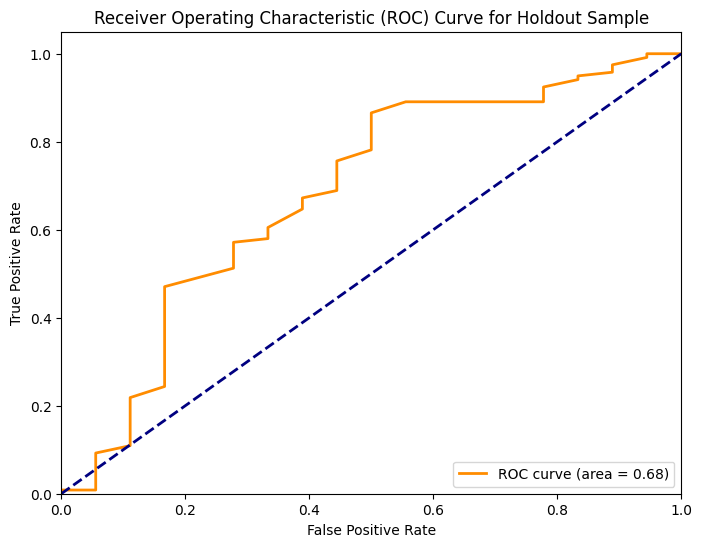

In [125]:
# Compute ROC curve and ROC area for the holdout set
# y_test_lin_reg_pred = subset_2_test_categorical_dummies['Model_Prediction'].values
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, normalised_scores)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for the holdout set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Holdout Sample')
plt.legend(loc="lower right")
plt.show()

#### AUROC

In [126]:
# Calculate the AUC (Area under the ROC Curve) which is equivalent to Somers' D
roc_auc = auc(fpr_test, tpr_test)
roc_auc

0.6825396825396826

#### Gini coefficient

In [127]:
Gini = roc_auc * 2 - 1
Gini

0.3650793650793651

#### Confusion Matrix, Sensitivity, Specificity.

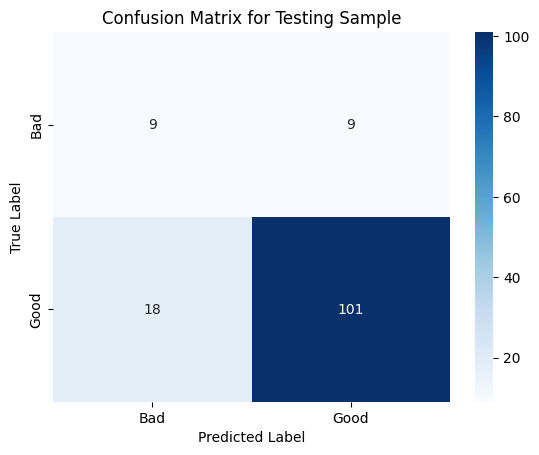

In [128]:
# Generate the confusion matrix
conf_matrix_test = confusion_matrix(y_test, (normalised_scores >= 0.5).astype(int))

# Display the confusion matrix using seaborn for better visualization
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Testing Sample')
plt.show()

In [129]:
# Extract values from the confusion matrix
TN, FP, FN, TP = conf_matrix_test.ravel()

# Calculate Sensitivity (True Positive Rate)
sensitivity = TP / (TP + FN)

# Calculate Specificity (True Negative Rate)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.8487394957983193
Specificity: 0.5


#### KS Statistic

In [130]:
# Create dataframne to be used in KS function
# Construct a dictionary from the lists
lin_reg_subset_2_test_KS = {'Predicted': normalised_scores, 'True': y_test.values}
# Create a DataFrame
lin_reg_subset_2_test_KSdf = pd.DataFrame(lin_reg_subset_2_test_KS)

lin_reg_subset_2_test_KSdf

,Predicted,True
0,0.481013,1
1,0.772152,1
2,0.734177,1
3,0.658228,1
4,0.708861,1
...,...,...
132,0.772152,1
133,0.658228,1
134,1.000000,1
135,0.556962,1


In [131]:
ks_df = ks(data=lin_reg_subset_2_test_KSdf,target="True", prob="Predicted")
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.873418,1.000000,11,1,9.24%,5.56%,9.24%,5.56%,3.7
2,0.784810,0.860759,15,1,12.61%,5.56%,21.85%,11.11%,10.7
3,0.746835,0.772152,11,1,9.24%,5.56%,31.09%,16.67%,14.4
4,0.708861,0.734177,15,0,12.61%,0.00%,43.70%,16.67%,27.0
5,0.670886,0.696203,9,2,7.56%,11.11%,51.26%,27.78%,23.5
6,0.632911,0.658228,11,1,9.24%,5.56%,60.50%,33.33%,27.2
7,0.556962,0.620253,16,2,13.45%,11.11%,73.95%,44.44%,29.5
8,0.518987,0.544304,9,1,7.56%,5.56%,81.51%,50.00%,31.5
9,0.443038,0.506329,11,5,9.24%,27.78%,90.76%,77.78%,13.0


In [132]:
lin_reg_subset_2_ks = np.max(ks_df['KS']) / 100
print(f"KS for this scorecard = {lin_reg_subset_2_ks}")

KS for this scorecard = 0.315


## Subset 1

### Pre-process testing data

#### Binning

In [133]:
# Define custom bin edges
subset_1_duration_bin_edges = [-float('inf'), 11.50, 15.50, 28.50, 43.50, float('inf')]

# Compute bin indices using np.digitize
subset_1_duration_bin_indices = np.digitize(subset_1_test['Duration'], subset_1_duration_bin_edges) - 1
# print(subset_1_duration_bin_indices)

# Map bin indices to bin labels
subset_1_test['Duration_Bin'] = [subset_1_duration_bin_labels[i] for i in subset_1_duration_bin_indices]
subset_1_test[['Duration','Duration_Bin']]

,Duration,Duration_Bin
899,18,"[15.50, 28.50)"
481,24,"[15.50, 28.50)"
77,11,"(-inf, 11.50)"
752,12,"[11.50, 15.50)"
732,8,"(-inf, 11.50)"
...,...,...
845,21,"[15.50, 28.50)"
878,9,"(-inf, 11.50)"
529,6,"(-inf, 11.50)"
992,18,"[15.50, 28.50)"


In [134]:
purpose_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: "[5,4,8]", 5: "[5,4,8]", 6: 6, 7: 7, 8: "[5,4,8]", 9: 9}
subset_1_test['Purpose_Bin'] = subset_1_test['Purpose'].map(purpose_mapping)

In [135]:
savings_mapping = {1: 1, 2: 2, 3: "[3,4]", 4: "[3,4]", 5: 5}
subset_1_test['Savings_Bin'] = subset_1_test['Savings'].map(savings_mapping)

#### Dummy Classifying

In [136]:
columns_to_keep = ['Duration_Bin','Purpose_Bin','Savings_Bin','History']

subset_1_test_preprocessed = subset_1_test[columns_to_keep]
subset_1_test_preprocessed

,Duration_Bin,Purpose_Bin,Savings_Bin,History
899,"[15.50, 28.50)",2,1,2
481,"[15.50, 28.50)",0,1,2
77,"(-inf, 11.50)",3,1,3
752,"[11.50, 15.50)",9,2,2
732,"(-inf, 11.50)",3,1,2
...,...,...,...,...
845,"[15.50, 28.50)",2,5,2
878,"(-inf, 11.50)",0,1,2
529,"(-inf, 11.50)",0,1,2
992,"[15.50, 28.50)",3,5,2


In [137]:
# dummy variables
data_dummies1 = [pd.get_dummies(subset_1_test_preprocessed['Duration_Bin'], prefix='Duration_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_1_test_preprocessed['Purpose_Bin'], prefix='Purpose_Bin', prefix_sep=':'),
                 pd.get_dummies(subset_1_test_preprocessed['History'], prefix='History', prefix_sep=':'),
                 pd.get_dummies(subset_1_test_preprocessed['Savings_Bin'], prefix='Savings_Bin', prefix_sep=':'),
                ]

In [138]:
# turn  data_dummies into dataframe

subset_1_test_categorical_dummies = pd.concat(data_dummies1, axis=1)
subset_1_test_categorical_dummies.astype(int)

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)",...,Savings_Bin:1,Savings_Bin:2,Savings_Bin:5,"Savings_Bin:[3,4]"
899,0,0,1,0,...,1,0,0,0
481,0,0,1,0,...,1,0,0,0
77,1,0,0,0,...,1,0,0,0
752,0,1,0,0,...,0,1,0,0
732,1,0,0,0,...,1,0,0,0
...,...,...,...,...,...,...,...,...,...
845,0,0,1,0,...,0,0,1,0
878,1,0,0,0,...,1,0,0,0
529,1,0,0,0,...,1,0,0,0
992,0,0,1,0,...,0,0,1,0


#### Dropping category

In [139]:
#dummy categories to drop
ref_categories = ["Savings_Bin:[3,4]", 'History:0', "Purpose_Bin:[5,4,8]",'Duration_Bin:[43.50, inf)']
subset_1_test_categorical_dummies.drop(columns=ref_categories, inplace=True, axis=1)

In [140]:
# subset_1_test_categorical_dummies

In [141]:
subset_1_test_categorical_dummies = subset_1_test_categorical_dummies.astype(int)
subset_1_test_categorical_dummies

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)",...,History:4,Savings_Bin:1,Savings_Bin:2,Savings_Bin:5
899,0,0,1,0,...,0,1,0,0
481,0,0,1,0,...,0,1,0,0
77,1,0,0,0,...,0,1,0,0
752,0,1,0,0,...,0,0,1,0
732,1,0,0,0,...,0,1,0,0
...,...,...,...,...,...,...,...,...,...
845,0,0,1,0,...,0,0,0,1
878,1,0,0,0,...,0,1,0,0
529,1,0,0,0,...,0,1,0,0
992,0,0,1,0,...,0,0,0,1


In [142]:
# Include Good column
subset_1_test_categorical_dummies['Good'] = subset_1_test['Good']
subset_1_test_categorical_dummies

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)",...,Savings_Bin:1,Savings_Bin:2,Savings_Bin:5,Good
899,0,0,1,0,...,1,0,0,0
481,0,0,1,0,...,1,0,0,1
77,1,0,0,0,...,1,0,0,1
752,0,1,0,0,...,0,1,0,1
732,1,0,0,0,...,1,0,0,1
...,...,...,...,...,...,...,...,...,...
845,0,0,1,0,...,0,0,1,1
878,1,0,0,0,...,1,0,0,0
529,1,0,0,0,...,1,0,0,1
992,0,0,1,0,...,0,0,1,1


In [143]:
# subset_1_test

### Logistic Regression Model

#### ROC

In [144]:
# Preparing the data for linear regression
X_test = subset_1_test_categorical_dummies.drop('Good', axis=1)  # Features
# y = subset_2_train['Good']  # Target variable
y_test = subset_1_test_categorical_dummies['Good']  # Target variable

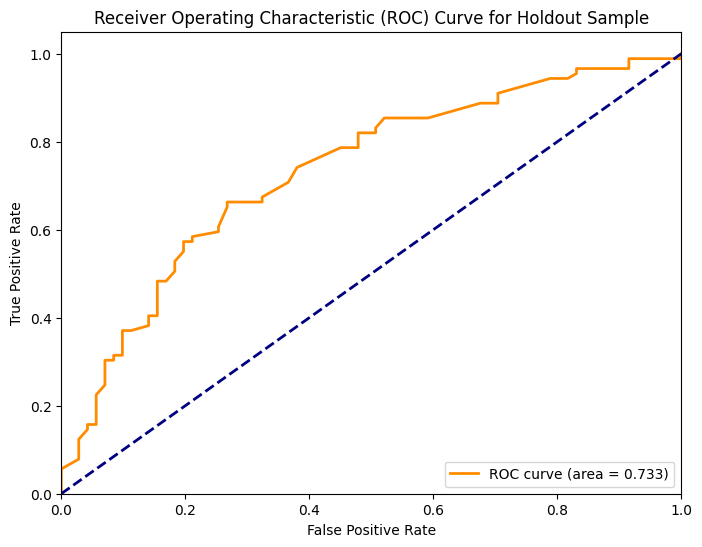

In [145]:
# We need to add a constant to the holdout data for the prediction
X_test_const = sm.add_constant(X_test)

# Predict probabilities for the positive class (1) for the holdout set using the trained model
y_test_pred_prob = subset_1_log_reg_results.predict(X_test_const)

# Compute ROC curve and ROC area for the holdout set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for the holdout set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Holdout Sample')
plt.legend(loc="lower right")
plt.show()

#### AUROC

In [146]:
# Calculate the AUC (Area under the ROC Curve) which is equivalent to Somers' D
roc_auc = auc(fpr_test, tpr_test)
roc_auc

0.7327108719734134

#### Gini coefficient

In [147]:
Gini = roc_auc * 2 - 1
Gini

0.4654217439468269

#### Confusion Matrix, Sensitivity, Specificity.

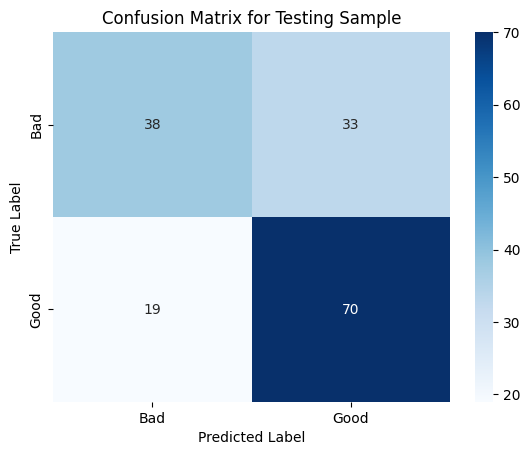

In [148]:
# Assuming 0.5 is the threshold, convert predicted probabilities to class labels based on a 0.5 threshold
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using seaborn for better visualization
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Testing Sample')
plt.show()

In [149]:
# Extract values from the confusion matrix
TN, FP, FN, TP = conf_matrix_test.ravel()

# Calculate Sensitivity (True Positive Rate)
sensitivity = TP / (TP + FN)

# Calculate Specificity (True Negative Rate)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.7865168539325843
Specificity: 0.5352112676056338


#### KS statistic

In [150]:
# Create dataframne to be used in KS function
# Construct a dictionary from the lists
log_reg_subset_1_test_KS = {'Predicted': y_test_pred_prob, 'True': y_test.values}
# Create a DataFrame
log_reg_subset_1_test_KSdf = pd.DataFrame(log_reg_subset_1_test_KS)

log_reg_subset_1_test_KSdf

,Predicted,True
899,0.434457,0
481,0.328541,1
77,0.852630,1
752,0.719988,1
732,0.764489,1
...,...,...
845,0.801968,1
878,0.606141,0
529,0.606141,1
992,0.844732,1


In [151]:
ks_df = ks(data=log_reg_subset_1_test_KSdf,target="True", prob="Predicted")
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.855558,0.956996,13,3,14.61%,4.23%,14.61%,4.23%,10.4
2,0.790472,0.852630,14,2,15.73%,2.82%,30.34%,7.04%,23.3
3,0.716709,0.780726,9,6,10.11%,8.45%,40.45%,15.49%,25.0
4,0.629398,0.715799,13,3,14.61%,4.23%,55.06%,19.72%,35.3
5,0.573039,0.628354,10,7,11.24%,9.86%,66.29%,29.58%,36.7
6,0.521009,0.572510,7,6,7.87%,8.45%,74.16%,38.03%,36.1
7,0.436687,0.507884,8,9,8.99%,12.68%,83.15%,50.70%,32.4
8,0.399076,0.434457,5,13,5.62%,18.31%,88.76%,69.01%,19.7
9,0.314627,0.398727,6,10,6.74%,14.08%,95.51%,83.10%,12.4


In [152]:
log_reg_subset_1_ks = np.max(ks_df['KS']) / 100
print(f"KS for this scorecard = {log_reg_subset_1_ks}")

KS for this scorecard = 0.36700000000000005


### Linear Regression Model

#### ROC

In [153]:
subset_1_test_categorical_dummies['Score_Regression'] = (X_test.dot(subset_1_lin_reg_scaled_coefficients) + subset_1_lin_reg_scaled_intercept)
subset_1_test_categorical_dummies

,"Duration_Bin:(-inf, 11.50)","Duration_Bin:[11.50, 15.50)","Duration_Bin:[15.50, 28.50)","Duration_Bin:[28.50, 43.50)",...,Savings_Bin:2,Savings_Bin:5,Good,Score_Regression
899,0,0,1,0,...,0,0,0,45.0
481,0,0,1,0,...,0,0,1,36.0
77,1,0,0,0,...,0,0,1,86.0
752,0,1,0,0,...,1,0,1,71.0
732,1,0,0,0,...,0,0,1,74.0
...,...,...,...,...,...,...,...,...,...
845,0,0,1,0,...,0,1,1,75.0
878,1,0,0,0,...,0,0,0,59.0
529,1,0,0,0,...,0,0,1,59.0
992,0,0,1,0,...,0,1,1,81.0


In [154]:
# Check range of score
score_range = subset_1_test_categorical_dummies['Score_Regression'].max() - subset_1_test_categorical_dummies['Score_Regression'].min()
min_score = subset_1_test_categorical_dummies['Score_Regression'].min()
max_score = subset_1_test_categorical_dummies['Score_Regression'].max()

score_range, min_score, max_score

(118.0, -9.0, 109.0)

In [155]:
# Normalize the credit score to range between 0 and 1
lin_reg_test_scores = subset_1_test_categorical_dummies['Score_Regression'].values
normalised_scores = (lin_reg_test_scores - np.min(lin_reg_test_scores)) / (np.max(lin_reg_test_scores) - np.min(lin_reg_test_scores))
normalised_scores

array([0.45762712, 0.38135593, 0.80508475, 0.6779661 , 0.70338983,
       0.44067797, 0.59322034, 0.44915254, 0.50847458, 0.53389831,
       0.44067797, 0.70338983, 0.57627119, 0.50847458, 0.44915254,
       0.28813559, 0.25423729, 0.38135593, 0.38983051, 0.41525424,
       0.75423729, 0.60169492, 0.60169492, 0.77966102, 0.38983051,
       0.52542373, 0.57627119, 0.53389831, 0.36440678, 0.65254237,
       0.8559322 , 0.50847458, 0.86440678, 0.78813559, 0.38135593,
       0.76271186, 0.98305085, 0.8559322 , 0.75423729, 0.45762712,
       0.36440678, 0.66101695, 0.50847458, 0.44915254, 0.22033898,
       0.70338983, 0.16101695, 0.72881356, 0.38135593, 0.8559322 ,
       0.63559322, 0.50847458, 0.95762712, 0.53389831, 0.45762712,
       0.65254237, 0.72881356, 0.73728814, 0.5       , 0.38983051,
       0.43220339, 0.57627119, 0.80508475, 0.60169492, 0.60169492,
       1.        , 0.52542373, 0.68644068, 0.53389831, 0.57627119,
       0.83050847, 0.46610169, 0.50847458, 0.70338983, 0.61016

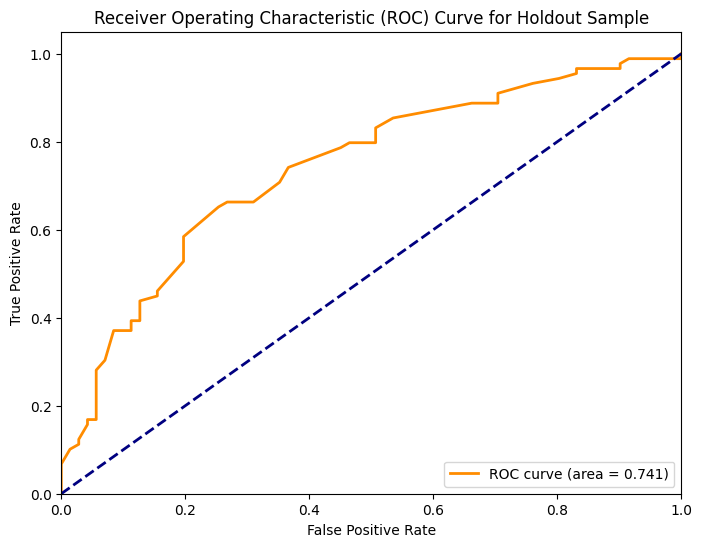

In [156]:
# Compute ROC curve and ROC area for the holdout set
# y_test_lin_reg_pred = subset_2_test_categorical_dummies['Model_Prediction'].values
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, normalised_scores)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for the holdout set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Holdout Sample')
plt.legend(loc="lower right")
plt.show()

#### AUROC

In [157]:
# Calculate the AUC (Area under the ROC Curve) which is equivalent to Somers' D
roc_auc = auc(fpr_test, tpr_test)
roc_auc

0.7413356543756923

#### Gini coefficient

In [158]:
Gini = roc_auc * 2 - 1
Gini

0.48267130875138453

#### Confusion Matrix, Sensitivity, Specificity.

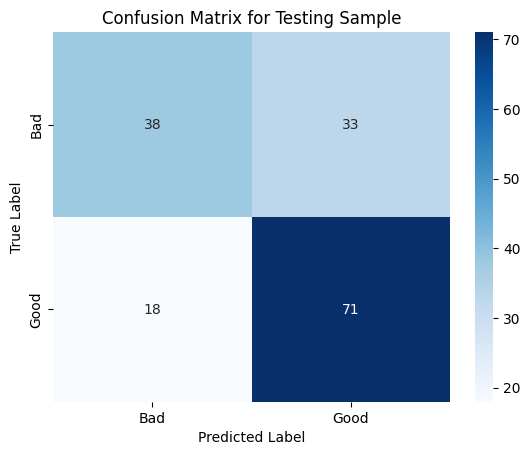

In [159]:
# Generate the confusion matrix
conf_matrix_test = confusion_matrix(y_test, (normalised_scores >= 0.5).astype(int))

# Display the confusion matrix using seaborn for better visualization
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Testing Sample')
plt.show()

In [160]:
# Extract values from the confusion matrix
TN, FP, FN, TP = conf_matrix_test.ravel()

# Calculate Sensitivity (True Positive Rate)
sensitivity = TP / (TP + FN)

# Calculate Specificity (True Negative Rate)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.797752808988764
Specificity: 0.5352112676056338


#### KS statistic

In [161]:
# Create dataframne to be used in KS function

# Construct a dictionary from the lists
lin_reg_subset_1_test_KS = {'Predicted': normalised_scores, 'True': y_test.values}

# Create a DataFrame
lin_reg_subset_1_test_KSdf = pd.DataFrame(lin_reg_subset_1_test_KS)

lin_reg_subset_1_test_KSdf

,Predicted,True
0,0.457627,0
1,0.381356,1
2,0.805085,1
3,0.677966,1
4,0.703390,1
...,...,...
155,0.711864,1
156,0.576271,0
157,0.576271,1
158,0.762712,1


In [162]:
# Create dataframne to be used in KS function

# Construct a dictionary from the lists
lin_reg_subset_1_test_KS = {'Predicted': normalised_scores, 'True': y_test.values}

# Create a DataFrame
lin_reg_subset_1_test_KSdf = pd.DataFrame(lin_reg_subset_1_test_KS)

lin_reg_subset_1_test_KSdf

ks_df = ks(data=lin_reg_subset_1_test_KSdf,target="True", prob="Predicted")
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.822034,1.000000,11,2,12.36%,2.82%,12.36%,2.82%,9.5
2,0.711864,0.805085,16,3,17.98%,4.23%,30.34%,7.04%,23.3
3,0.652542,0.703390,12,4,13.48%,5.63%,43.82%,12.68%,31.1
4,0.601695,0.635593,8,5,8.99%,7.04%,52.81%,19.72%,33.1
5,0.550847,0.593220,12,7,13.48%,9.86%,66.29%,29.58%,36.7
6,0.525424,0.542373,7,5,7.87%,7.04%,74.16%,36.62%,37.5
7,0.466102,0.508475,8,10,8.99%,14.08%,83.15%,50.70%,32.4
8,0.440678,0.457627,5,11,5.62%,15.49%,88.76%,66.20%,22.6
9,0.364407,0.432203,6,12,6.74%,16.90%,95.51%,83.10%,12.4


In [163]:
lin_reg_subset_1_ks = np.max(ks_df['KS']) / 100
print(f"KS for this scorecard = {lin_reg_subset_1_ks}")

KS for this scorecard = 0.375


## Results Analysis

**Brief description of Evaluaiton metrics**</br>
An ROC curve is a plot of Sensitivity (True Positive Rate (TPR)) against 1 - Specificity (False Positive Rate (FPR)). The interpretation of such is that a steep curve means that the model is achieving more true positives, while maintaining low false positives.

The AUROC is the Area Under the ROC curve. A perfect model would have an AUROC of 1 while an AUROC of 0.5 means that the model is effectively guessing. The Gini Coefficient is defined as 2*AUROC - 1. Therefore, the interpretation to the Gini Coefficient is essentially that a perfect model would have a coefficient of 1 while a model that guesses would have a coefficient of 0.

The confusion matrix provides us with more insight into the predicitons of the models such as the number of true negatives and false negatives it makes etc.

The KS statistic is the maximum absolute difference between the cumulative distributions of the 'Good' and 'Bad' applicants and the metric can help us understand the models effectiveness in being able to differentiate between 'Good' and 'Bad' applicants.

**Subset 1 Linear Regression Model**</br>
- Gini Coefficient: 0.48
- KS statistic: 0.375

**Subset 1 Logistic Regression Model**</br>
- Gini Coefficient: 0.465
- KS statistic: 0.367

**Subset 2 Linear Regression Model**</br>
- Gini Coefficient: 0.365
- KS statistic: 0.315

**Subset 2 Logistic Regression Model**</br>
- Gini Coefficient: 0.3296
- KS statistic: 0.305

Comapring just the two models between subset 1, we can see that the linear regression model has a higher gini coefficient and KS statistic indicating that it's able to differentiate between 'Good' and 'Bad applicants more effectively. However, this difference is not significant and we can observe from the ROC curves and the confusion matrix that the two models behave near enough identically.

Similarly for subset two, the Gini coefficient and KS statistics suggests that the Linear Regression model performs better on the validation set.

Another interesting observation is that the models tend to perform better on subset 1 than they do on subset 2. This led me to do some more inspection into the two subsets and found the amount of 'Good' applicants in the train and test sets of subset 1 is around 55% and therefore the number of 'Bad' applicants around 45%. However, for the train and test sets of subset 2, the percentage of 'Good' applicants is around 87% and therefore the percentage of 'Bad' applicants being around 13%. This observation can potentially explain why the models on Subset 1 perform better as the models trained on subset 2 had very limited 'Bad' applicant examples to learn from and therefore you would expect that these models would not be able to detect a 'Bad' applicant as effectively.

Overall, the best performing model was the linear regression model from subset 1. It had an AUROC of around 74% which indicates relatively good predictive ability. However, there is still definitely room for improvement and I think that with better variables, this model can definitely perform better. I think  this because the variables used to train this model only had medium predictive power.

Also could have potentially applied synthetic minority oversampling techniques in order to improve the models on subset 2.

In [164]:
print(subset_2_train['Good'].values.sum() / len(subset_2_train['Good'].values))
print(subset_2_test['Good'].values.sum() / len(subset_2_test['Good'].values))
print(subset_1_train['Good'].values.sum() / len(subset_1_train['Good'].values))
print(subset_1_test['Good'].values.sum() / len(subset_1_test['Good'].values))

0.8683385579937304
0.8686131386861314
0.5591397849462365
0.55625
